# Import libraries

In [ ]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib import rcParams
import missingno as msno

from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import TomekLinks
from sklearn.preprocessing import StandardScaler, MinMaxScaler, LabelEncoder
from sklearn.decomposition import PCA
from sklearn.model_selection import train_test_split

import pickle
from sklearn.model_selection import StratifiedKFold

from sklearn.ensemble import RandomForestClassifier, VotingClassifier, ExtraTreesClassifier, AdaBoostClassifier, GradientBoostingClassifier
from catboost import CatBoostClassifier
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier

from skopt import BayesSearchCV
from skopt.space import Real, Integer, Categorical
from skopt.callbacks import DeltaYStopper, DeadlineStopper

# Read data

In [2]:
train_data = pd.read_csv('data/train.csv')

In [5]:
train_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 32999 entries, 0 to 32998
Data columns (total 14 columns):
 #   Column                          Non-Null Count  Dtype  
---  ------                          --------------  -----  
 0   person_age                      32999 non-null  float64
 1   person_gender                   32999 non-null  object 
 2   person_education                32999 non-null  object 
 3   person_income                   32999 non-null  float64
 4   person_emp_exp                  32999 non-null  int64  
 5   person_home_ownership           32999 non-null  object 
 6   loan_amnt                       32999 non-null  float64
 7   loan_intent                     32999 non-null  object 
 8   loan_int_rate                   32999 non-null  float64
 9   loan_percent_income             32999 non-null  float64
 10  cb_person_cred_hist_length      32999 non-null  float64
 11  credit_score                    32999 non-null  int64  
 12  previous_loan_defaults_on_file  

In [6]:
train_data.describe()

person_age  person_income  person_emp_exp     loan_amnt  \
count  32999.000000   3.299900e+04    32999.000000  32999.000000   
mean      27.738568   8.038576e+04        5.516470   9587.230310   
std        6.333872   7.425788e+04        6.333516   6317.895438   
min       20.000000   8.000000e+03        0.000000    500.000000   
25%       23.000000   4.748550e+04        1.000000   5000.000000   
50%       26.000000   6.718800e+04        4.000000   8000.000000   
75%       30.000000   9.654300e+04        8.000000  12100.000000   
max      144.000000   7.200766e+06      125.000000  35000.000000   

       loan_int_rate  loan_percent_income  cb_person_cred_hist_length  \
count   32999.000000         32999.000000                32999.000000   
mean       11.001461             0.139147                    5.811358   
std         3.069164             0.086783                    4.050483   
min         5.420000             0.000000                    2.000000   
25%         8.490000             0.070000                    3.000000   
50%        11.010000             0.120000                    4.000000   
75%        13.110000             0.190000                    8.000000   
max        20.000000             0.660000                   30.000000   

       credit_score   loan_status  
count  32999.000000  32999.000000  
mean     633.003697      0.215400  
std       50.379861      0.411106  
min      390.000000      0.000000  
25%      602.000000      0.000000  
50%      640.000000      0.000000  
75%      670.000000      0.000000  
max      850.000000      1.000000

In [7]:
train_data.sample(5)

person_age person_gender person_education  person_income  \
1965         23.0        female      High School        15411.0   
17181        24.0          male      High School        95528.0   
13451        23.0          male           Master       111365.0   
31939        42.0          male        Associate       102682.0   
3075         26.0          male           Master        41542.0   

       person_emp_exp person_home_ownership  loan_amnt loan_intent  \
1965                1                  RENT     2100.0     MEDICAL   
17181               4                  RENT     8000.0     MEDICAL   
13451               3              MORTGAGE     4800.0   EDUCATION   
31939              22                  RENT     5750.0     MEDICAL   
3075                6                  RENT     3300.0     MEDICAL   

       loan_int_rate  loan_percent_income  cb_person_cred_hist_length  \
1965            8.94                 0.14                         2.0   
17181          11.49                 0.08                         4.0   
13451           7.49                 0.04                         2.0   
31939          12.99                 0.06                        14.0   
3075           15.65                 0.08                         4.0   

       credit_score previous_loan_defaults_on_file  loan_status  
1965            597                             No            1  
17181           652                            Yes            0  
13451           691                             No            0  
31939           634                            Yes            0  
3075            686                             No            0

# Plot Data

## Check missing value

All 32999 is non-null, also can check on above `.info()` of data

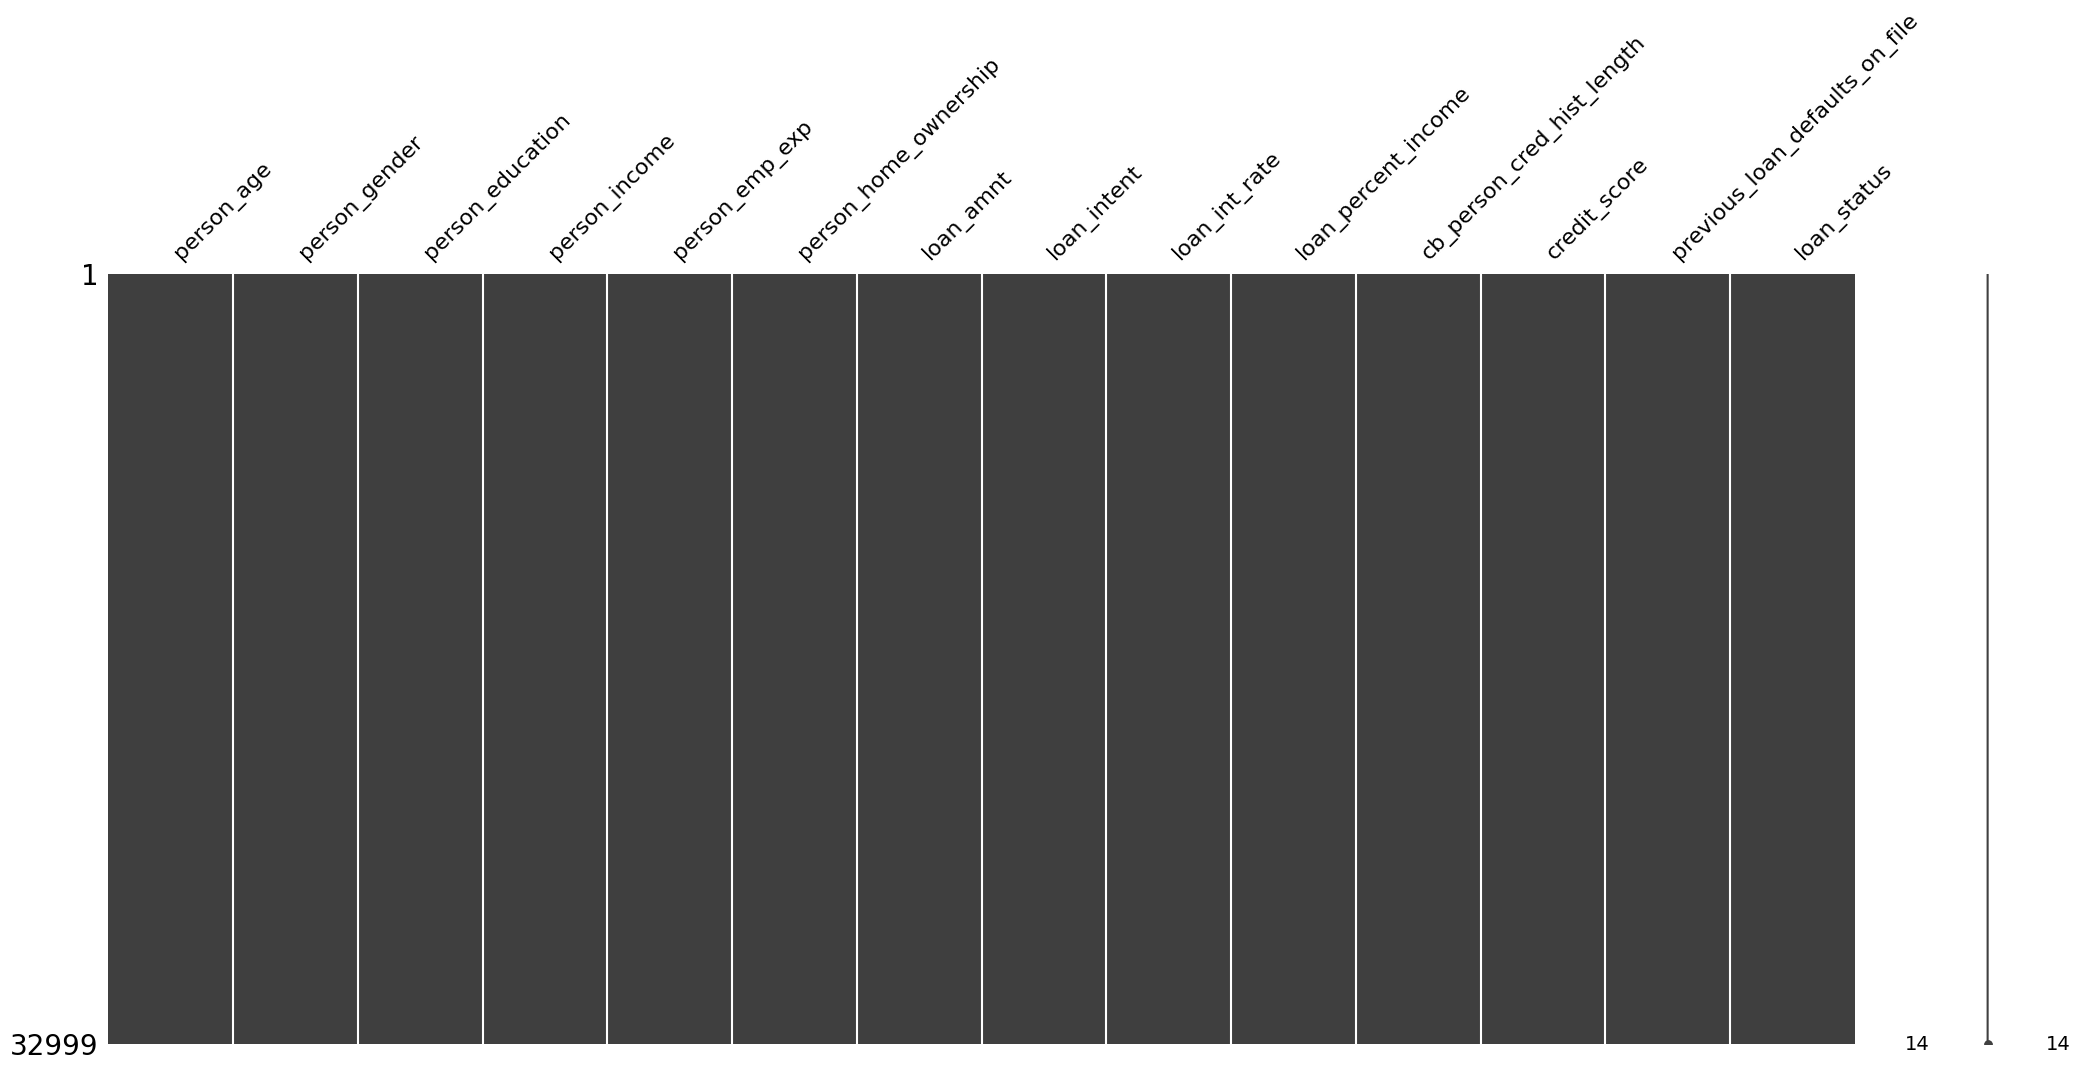

In [8]:
# Visualize missing values
msno.matrix(train_data)
plt.show()

## Check distribution of data

As plot, the label kinda fell off over the 0 label

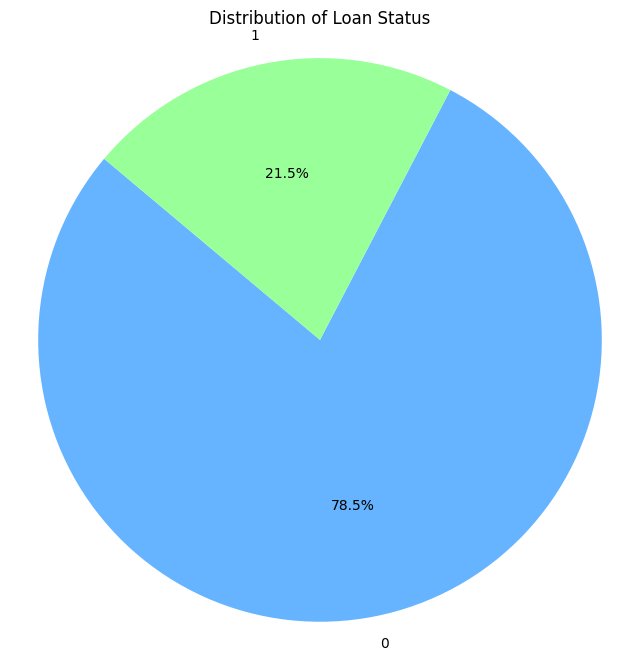

In [9]:
# Count the occurrences of each loan status
loan_status_counts = train_data['loan_status'].value_counts()

# Plot the pie chart
plt.figure(figsize=(8, 8))
plt.pie(loan_status_counts, labels=loan_status_counts.index, autopct='%1.1f%%', startangle=140, colors=['#66b3ff','#99ff99'])
plt.title('Distribution of Loan Status')
plt.axis('equal')  # Equal aspect ratio ensures that pie is drawn as a circle.
plt.show()

In [17]:
feature_names = [cname for cname in train_data.select_dtypes(include=['int64', 'float64']).columns]
feature_names.remove('loan_status')

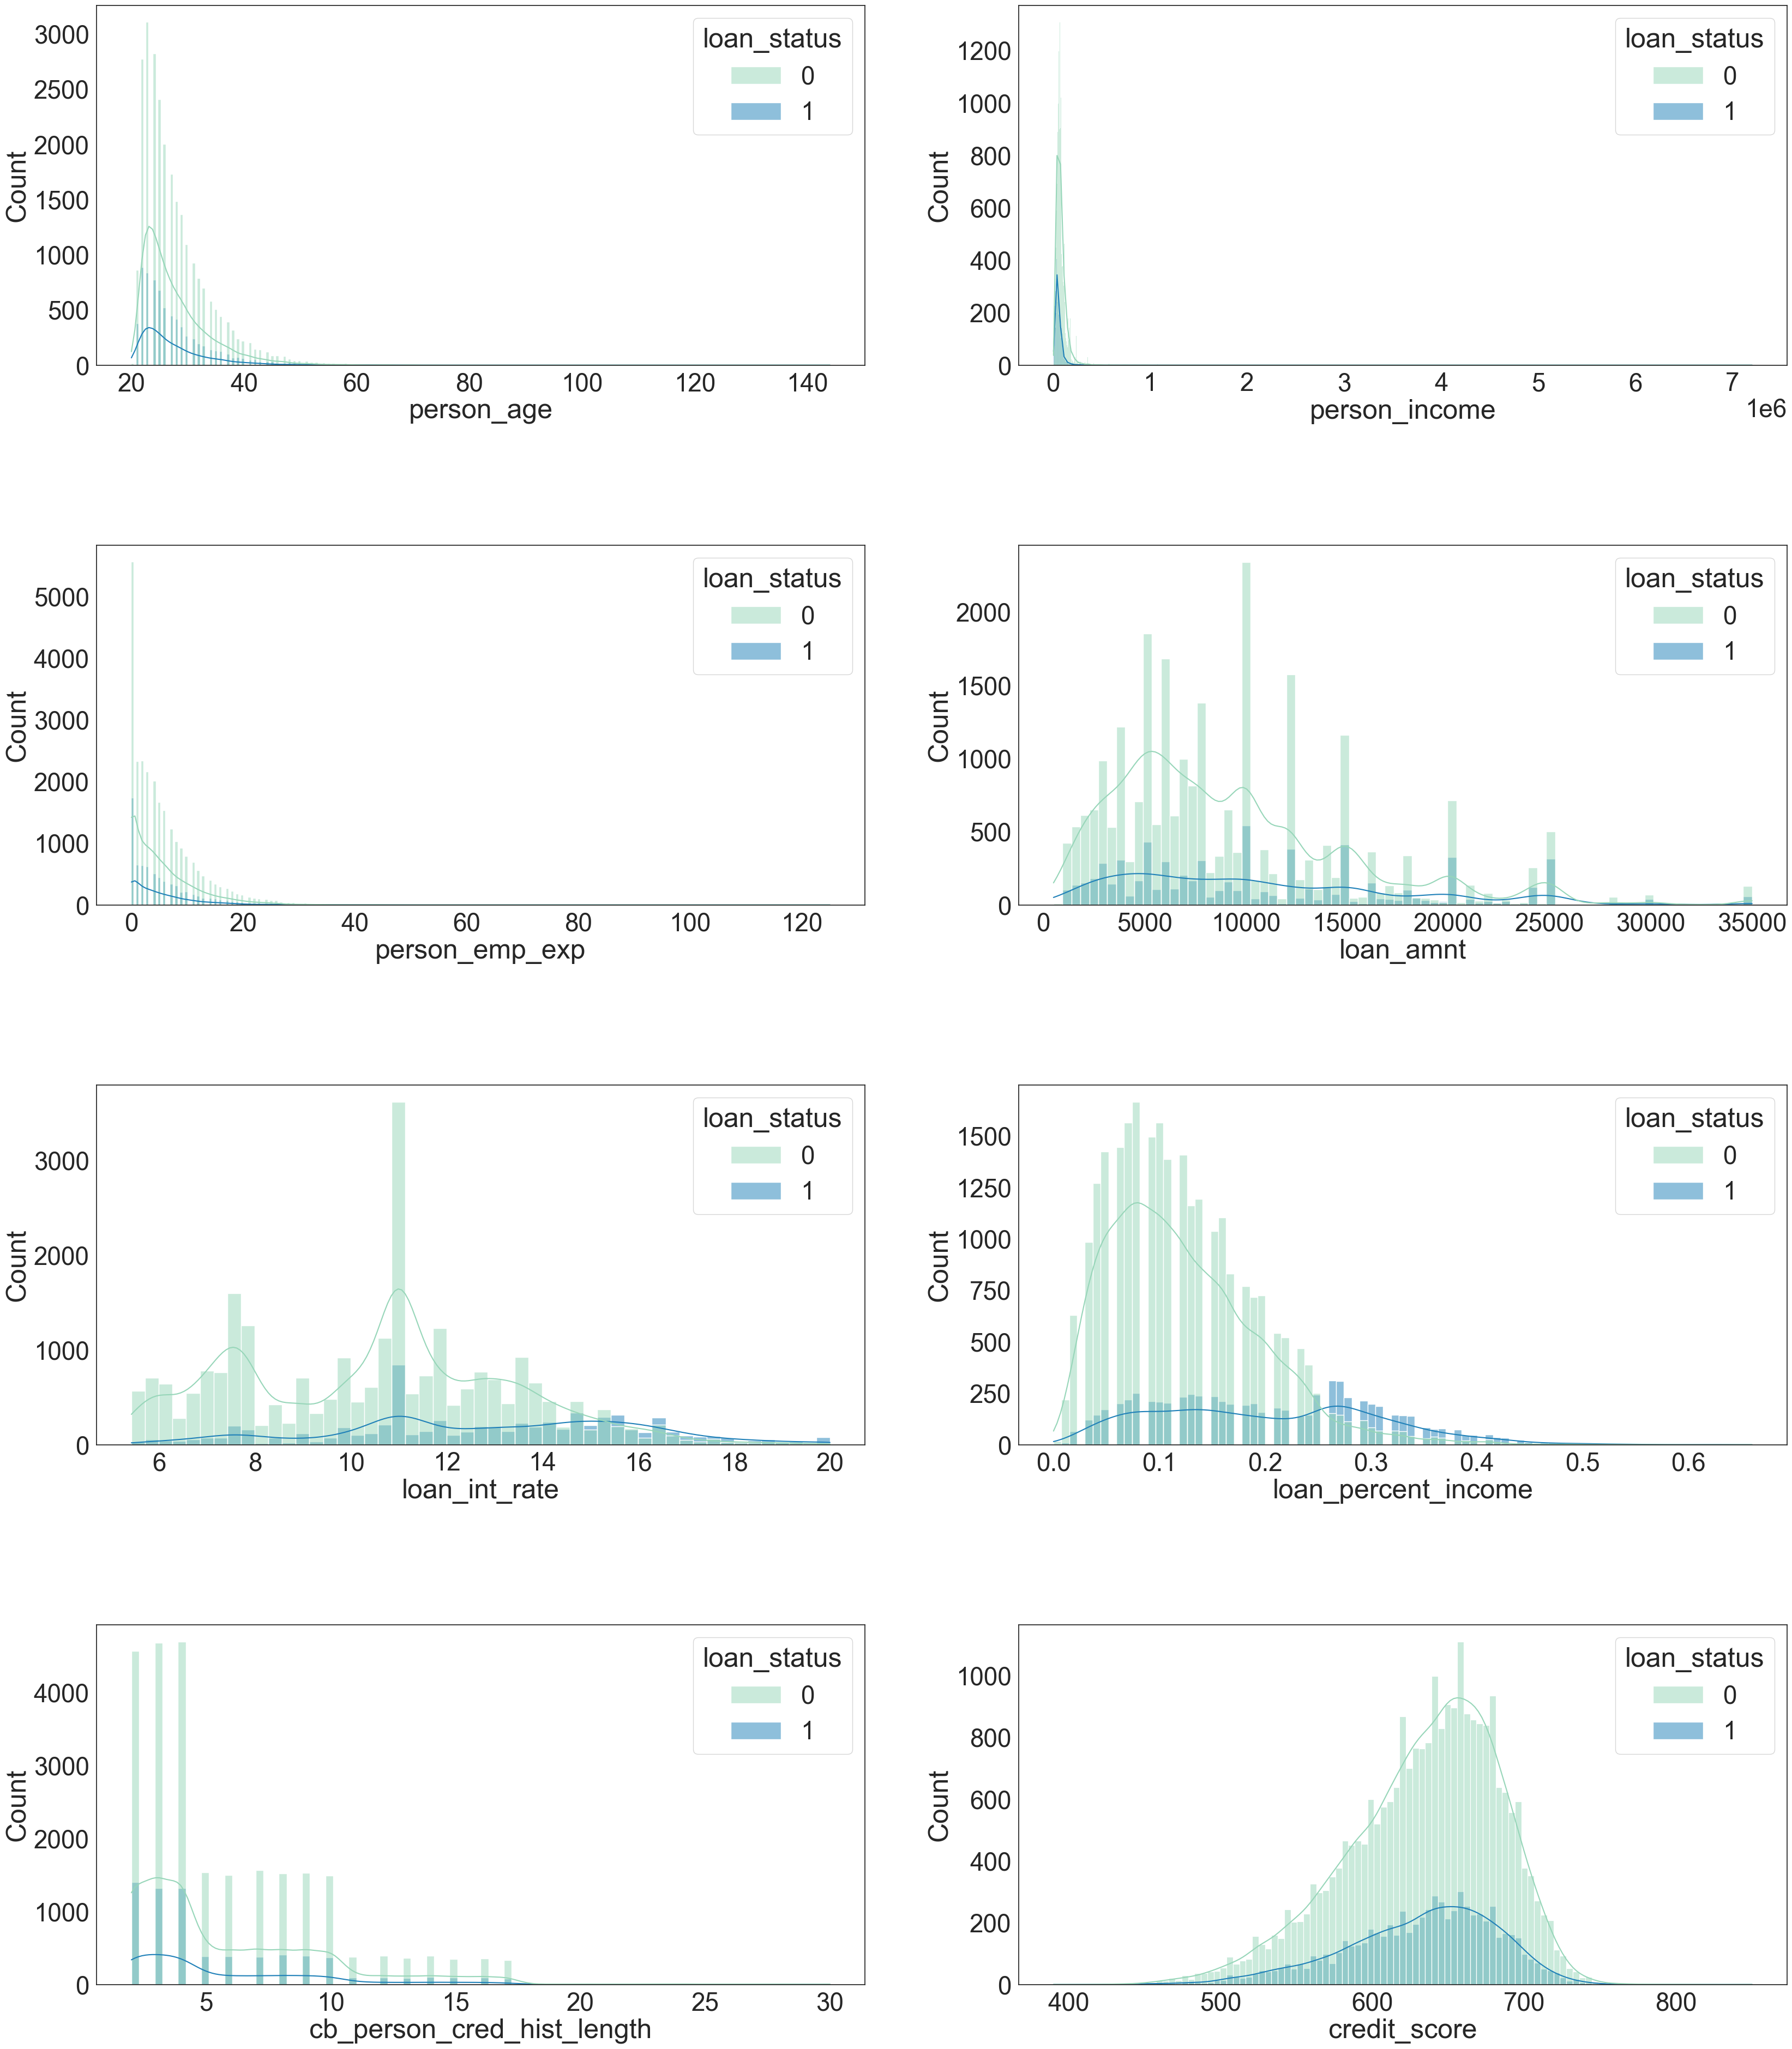

In [18]:
rcParams['figure.figsize'] = 40,60
sns.set(font_scale = 3)
sns.set_style("white")
sns.set_palette("bright")
plt.subplots_adjust(hspace=0.5)
i = 1
for name in feature_names:
    plt.subplot(5,2,i)
    sns.histplot(data=train_data, x=name, hue="loan_status",kde=True,palette="YlGnBu")
    i = i + 1

Seem like 3 columns `person_age`, `person_emp_exp`, `person_income` has a bit of outliners in top value, as check Q3 and Q4 is a range too far

In [11]:
non_numeric_features = train_data.select_dtypes(exclude=['int64', 'float64']).columns.to_list()

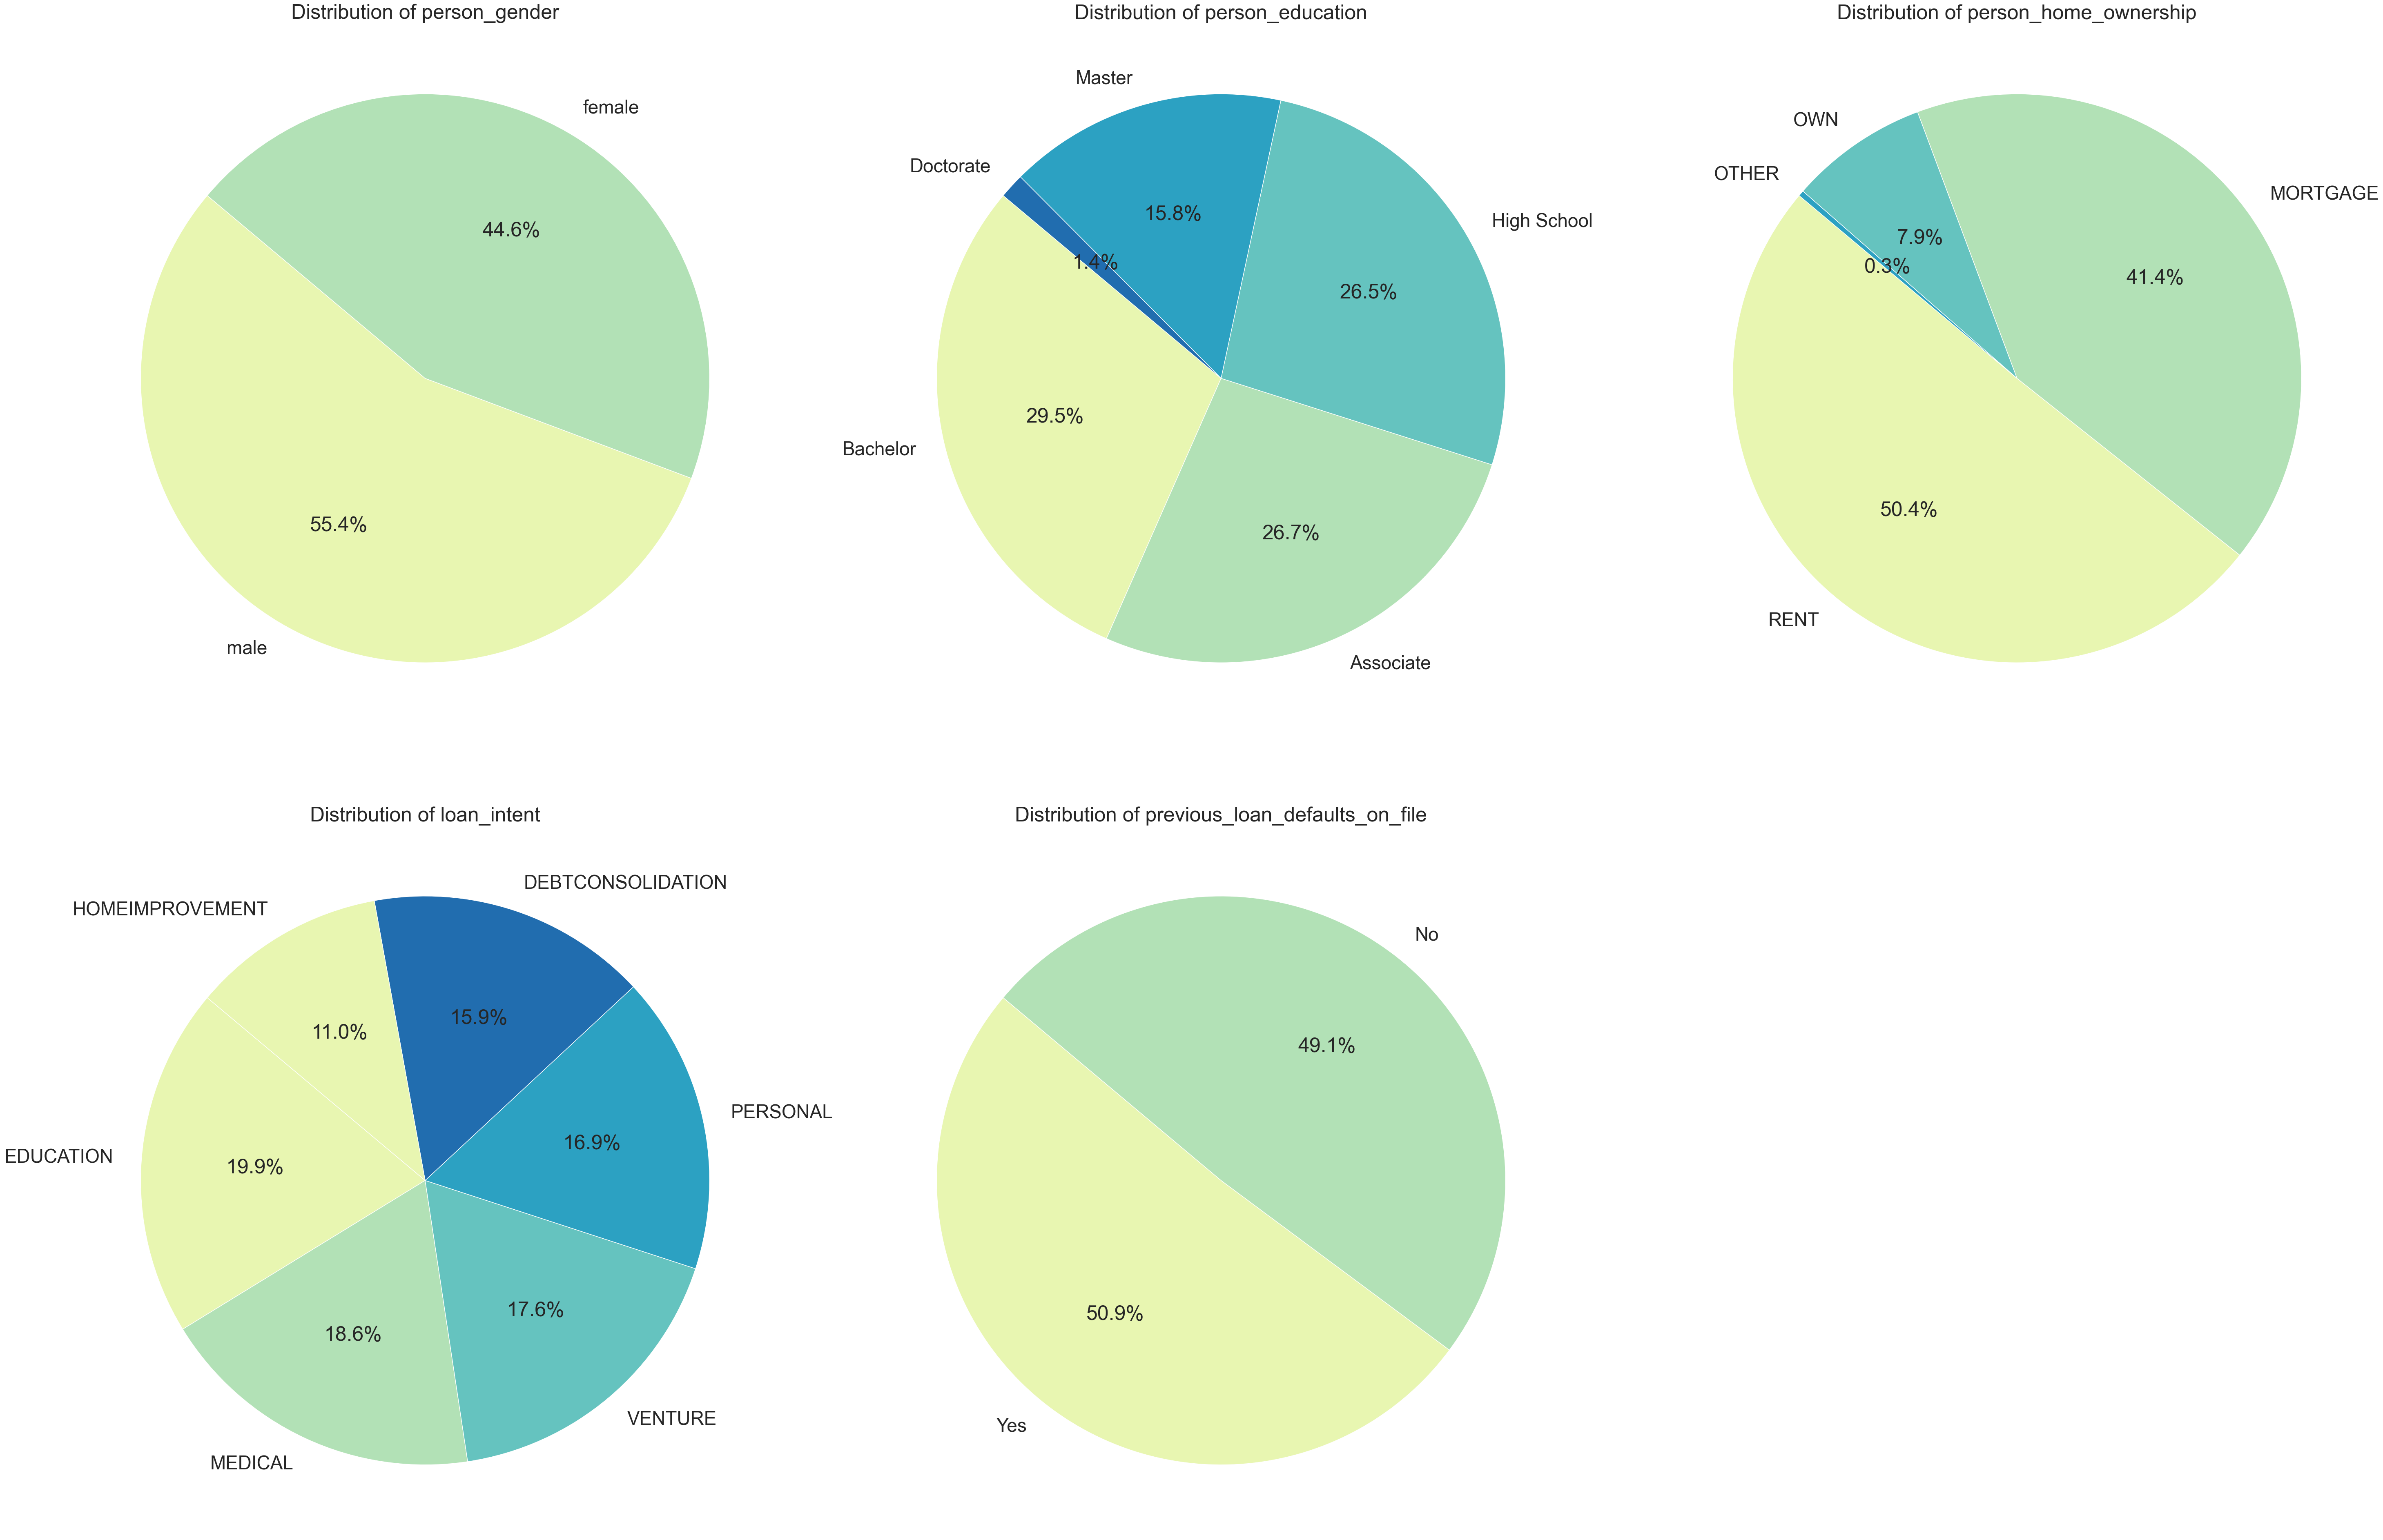

In [12]:
colors = sns.color_palette('YlGnBu')[0:5]
i = 1
plt.figure(figsize=(60, 40))
for name in non_numeric_features:
    plt.subplot(2, 3, i)
    train_data[name].value_counts().plot.pie(autopct='%1.1f%%', colors=colors, startangle=140)
    plt.title(f'Distribution of {name}')
    plt.ylabel('')
    i += 1
plt.tight_layout()
plt.show()

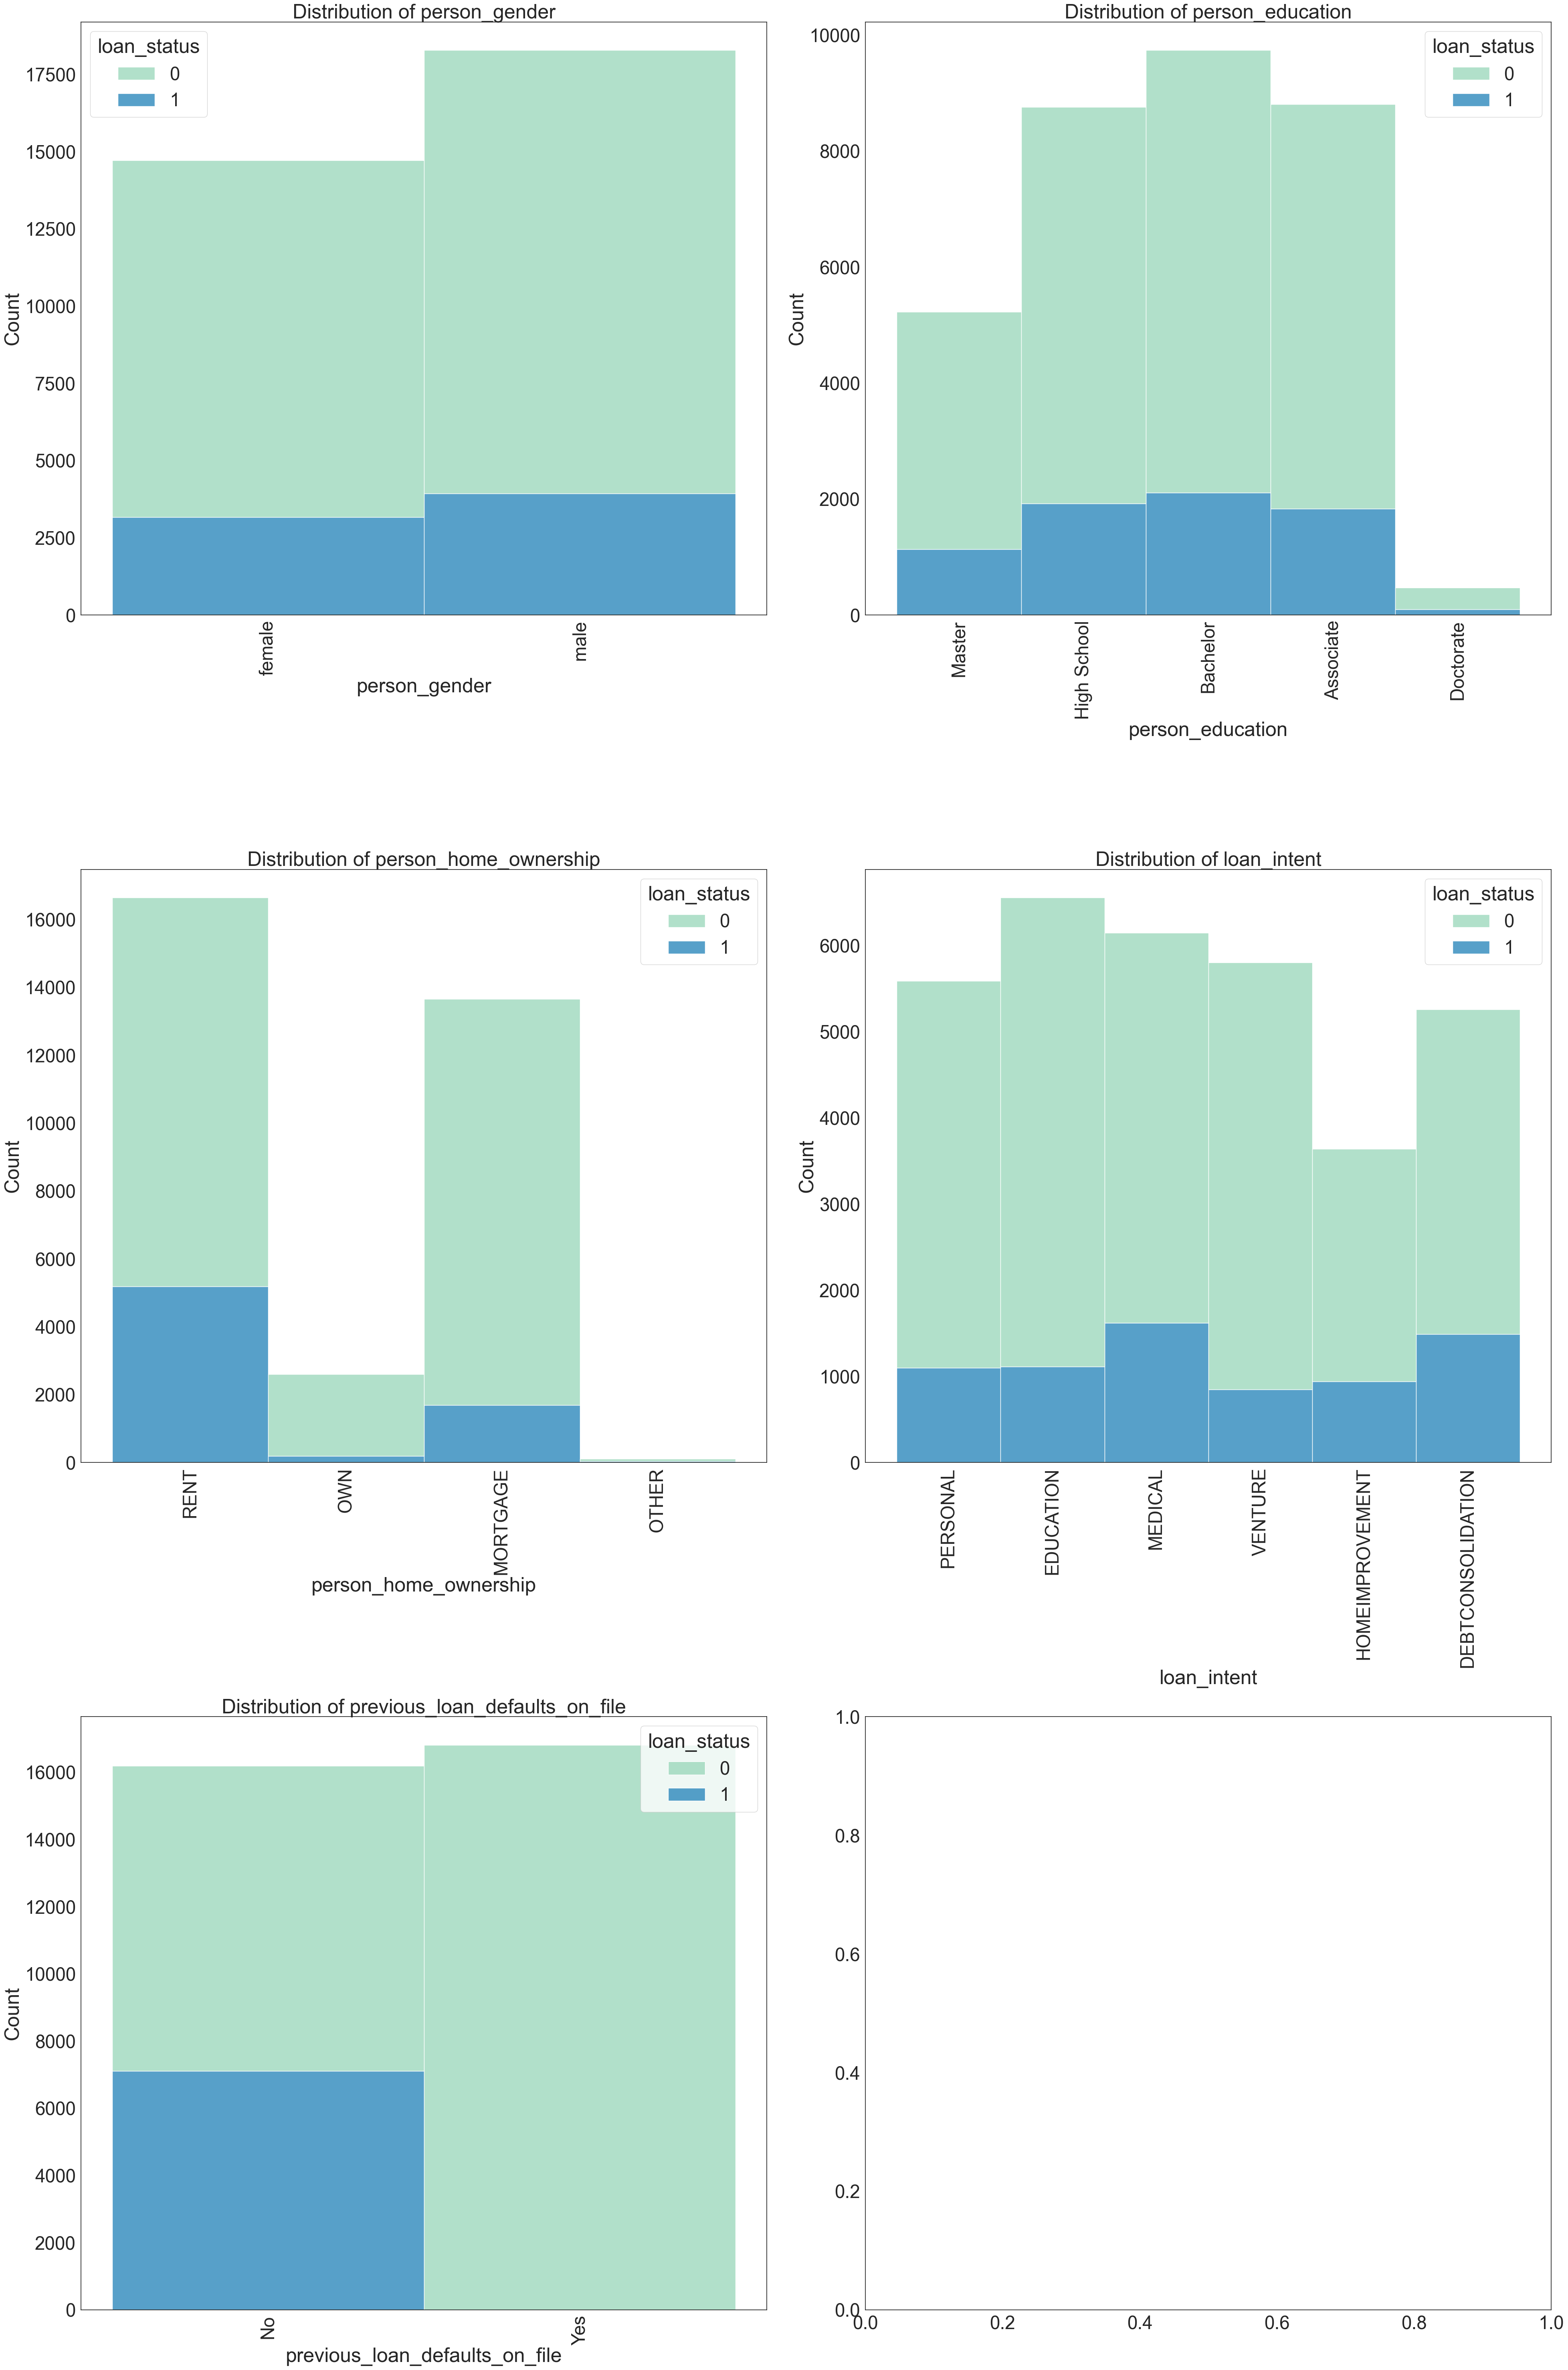

In [13]:
fig, axes = plt.subplots(3, 2, figsize=(40, 60))
axes = axes.flatten()

for i, feature in enumerate(non_numeric_features):
    sns.histplot(data=train_data, x=feature, hue="loan_status", multiple="stack", palette="YlGnBu", ax=axes[i])
    axes[i].set_title(f'Distribution of {feature}')
    axes[i].tick_params(axis='x', rotation=90)

plt.tight_layout()
plt.show()

# Data Process

## Remove Outliners

In [3]:
def remove_outliners(df, features):
    temp_df = df.copy()
    for feature in features:
        Q1 = temp_df[feature].quantile(0.25)
        Q3 = temp_df[feature].quantile(0.75)
        IQR = Q3 - Q1
        temp_df = temp_df[(temp_df[feature] >= (Q1 - 1.5 * IQR)) & (temp_df[feature] <= (Q3 + 1.5 * IQR))]
    return temp_df

In [4]:
features_to_remove_outliners = ['person_emp_exp', 'person_income', 'person_age']

train_data_trunc = remove_outliners(train_data, features_to_remove_outliners)

# Display the updated DataFrame
train_data_trunc.info()

<class 'pandas.core.frame.DataFrame'>
Index: 29435 entries, 0 to 32998
Data columns (total 14 columns):
 #   Column                          Non-Null Count  Dtype  
---  ------                          --------------  -----  
 0   person_age                      29435 non-null  float64
 1   person_gender                   29435 non-null  object 
 2   person_education                29435 non-null  object 
 3   person_income                   29435 non-null  float64
 4   person_emp_exp                  29435 non-null  int64  
 5   person_home_ownership           29435 non-null  object 
 6   loan_amnt                       29435 non-null  float64
 7   loan_intent                     29435 non-null  object 
 8   loan_int_rate                   29435 non-null  float64
 9   loan_percent_income             29435 non-null  float64
 10  cb_person_cred_hist_length      29435 non-null  float64
 11  credit_score                    29435 non-null  int64  
 12  previous_loan_defaults_on_file  29435

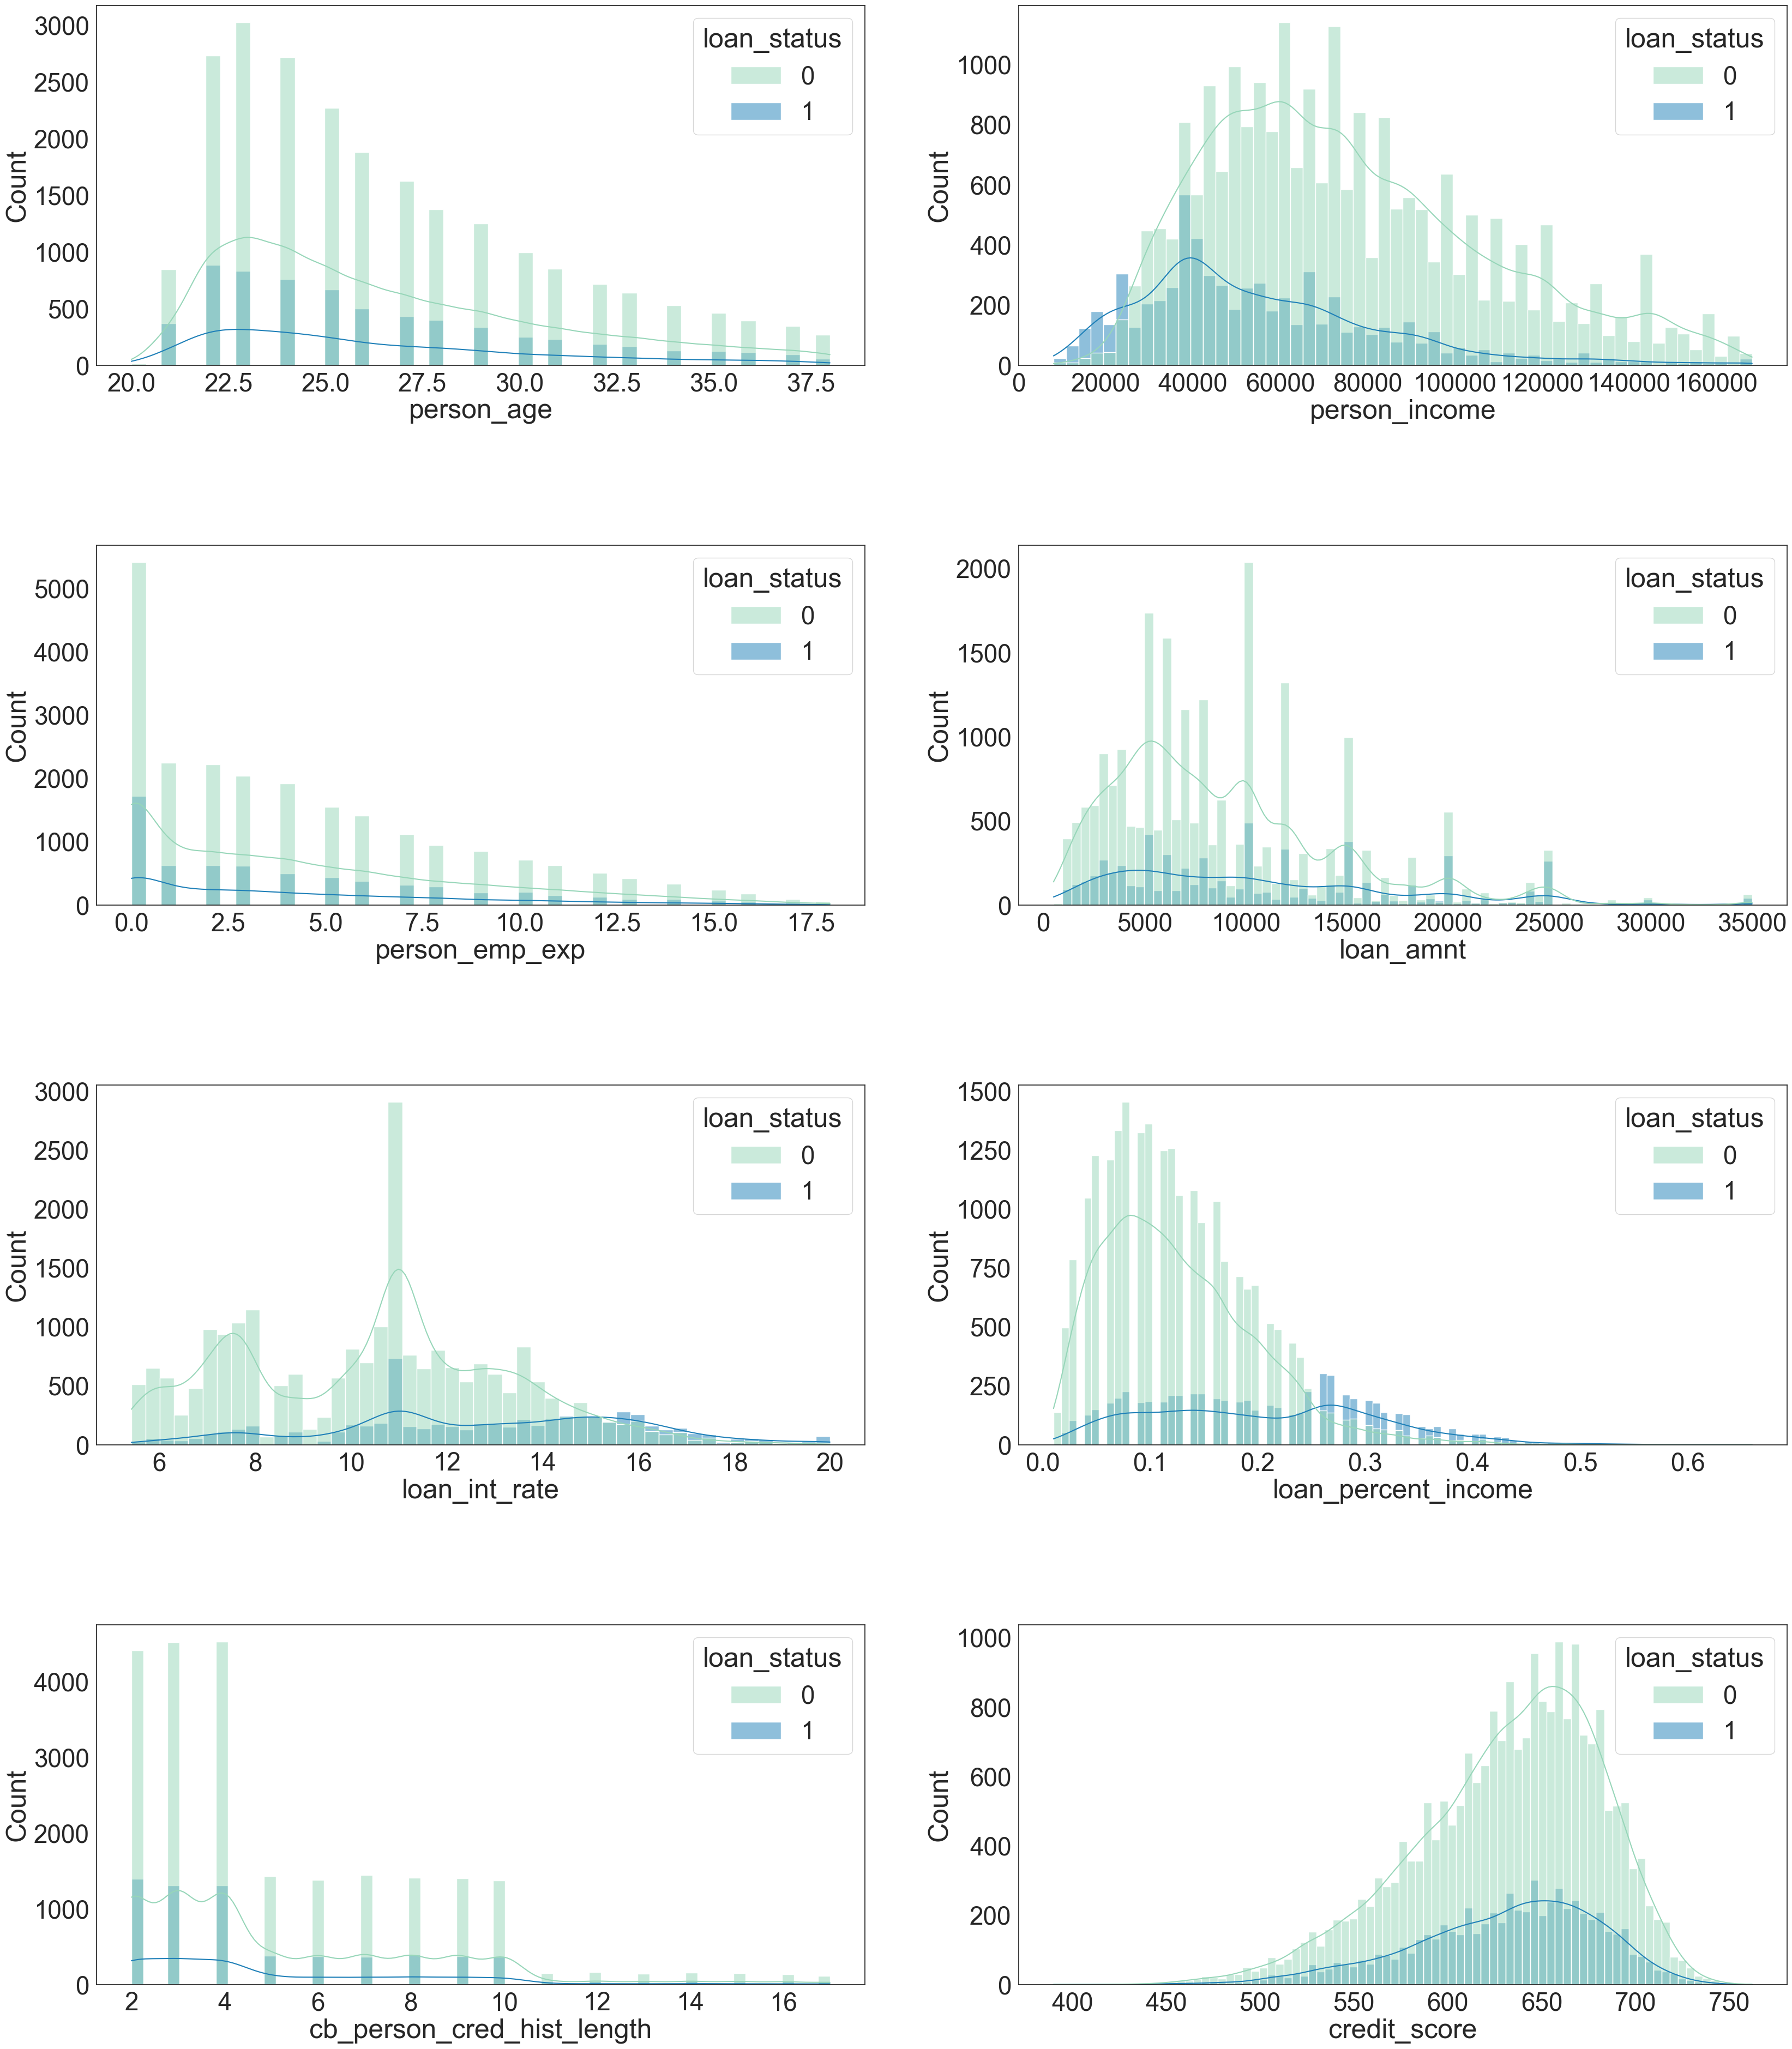

In [19]:
# Replot to see distribution

rcParams['figure.figsize'] = 40,60
sns.set(font_scale = 3)
sns.set_style("white")
sns.set_palette("bright")
plt.subplots_adjust(hspace=0.5)
i = 1
for name in feature_names:
    plt.subplot(5,2,i)
    sns.histplot(data=train_data_trunc, x=name, hue="loan_status",kde=True,palette="YlGnBu")
    i = i + 1

## Encoding data

In this datasets, the columns and categories is not much, then we can use one-hot encoding. In the below, we look at 2 kind of encode: simple label encoding and one-hot

In [5]:
def dataset_encode(train_data):
    df = train_data.copy()
    # Gender: to true false one-hot
    df['is_male'] = df['person_gender'].map({'male': 1, 'female': 0})
    df.drop(columns=['person_gender'], inplace=True)

    # Previous loan: to true false one-hot
    df['previous_loan_defaults_on_file'] = df['previous_loan_defaults_on_file'].map({'Yes': 1, 'No': 0})
    df.drop(columns=['previous_loan_defaults_on_file'], inplace=True)

    # Since education is low, using one-hot encoding
    df = pd.get_dummies(df, columns=['person_education'], prefix='edu', dtype=int)

    # Home ownership also has few categories, so using one-hot encoding
    df = pd.get_dummies(df, columns=['person_home_ownership'], prefix='home', dtype=int)

    # Load intent also has few categories, so using one-hot encoding
    df = pd.get_dummies(df, columns=['loan_intent'], prefix='intent', dtype=int)
    
    return df

def dataset_encode_label(train_data):
    df = train_data.copy()
    # Gender: to true false one-hot
    df['is_male'] = df['person_gender'].map({'male': 1, 'female': 0})
    df.drop(columns=['person_gender'], inplace=True)

    # Previous loan: to true false one-hot
    df['previous_loan_defaults_on_file'] = df['previous_loan_defaults_on_file'].map({'Yes': 1, 'No': 0})
    df.drop(columns=['previous_loan_defaults_on_file'], inplace=True)
    
    label_cols = ['person_education', 'person_home_ownership', 'loan_intent']
    label_enc = LabelEncoder()
    
    for col in label_cols:
        df[col] = label_enc.fit_transform(df[col])
    
    return df

In [20]:
train_data_tr_encode = dataset_encode(train_data_trunc)
correlation_matrix = train_data_tr_encode.corr()

<Axes: >

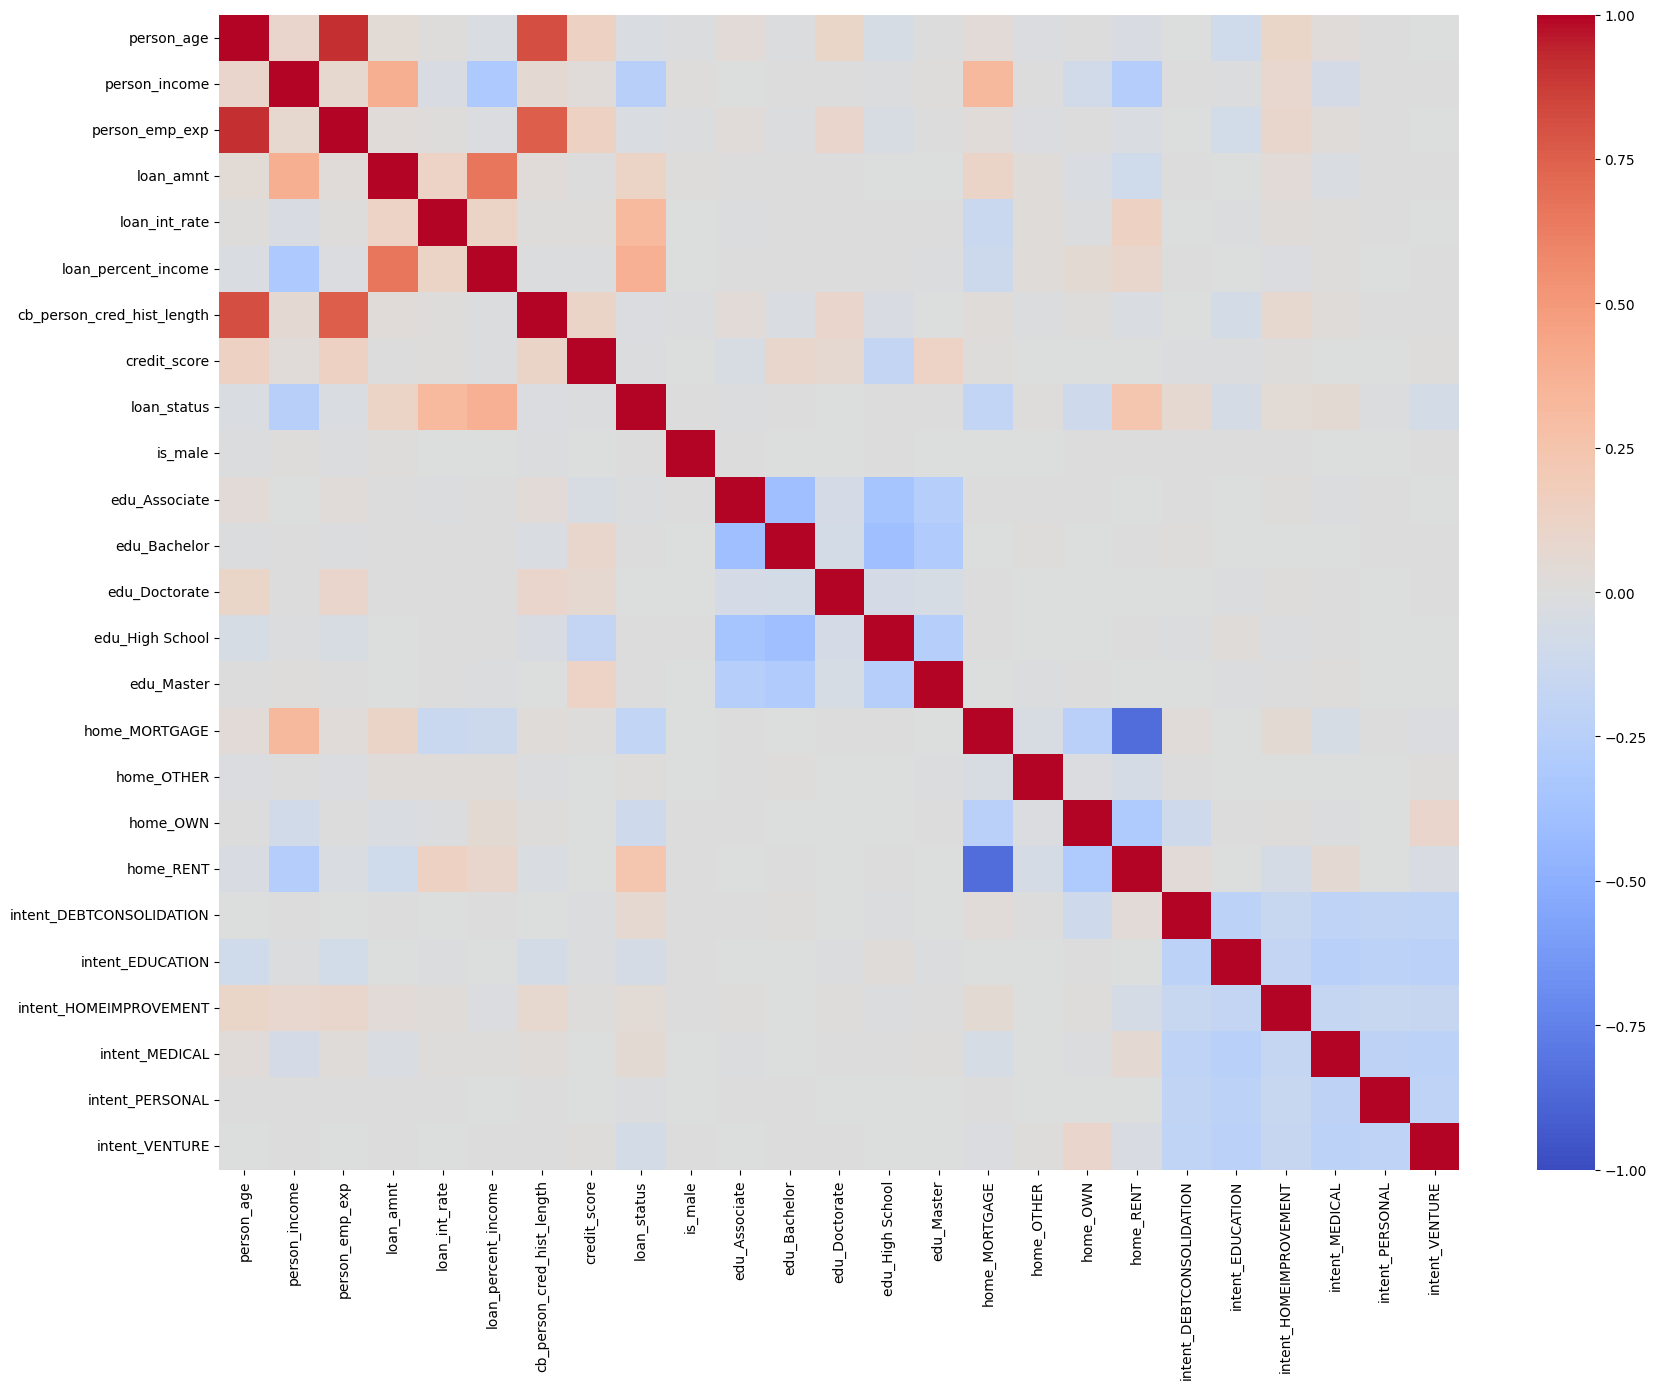

In [21]:
plt.figure(figsize=(20, 15))
sns.heatmap(correlation_matrix, annot=False, cmap='coolwarm', fmt=".2f", vmin=-1, vmax=1)

In [22]:
train_label_data_tr_encode = dataset_encode_label(train_data_trunc)
correlation_matrix = train_label_data_tr_encode.corr()

<Axes: >

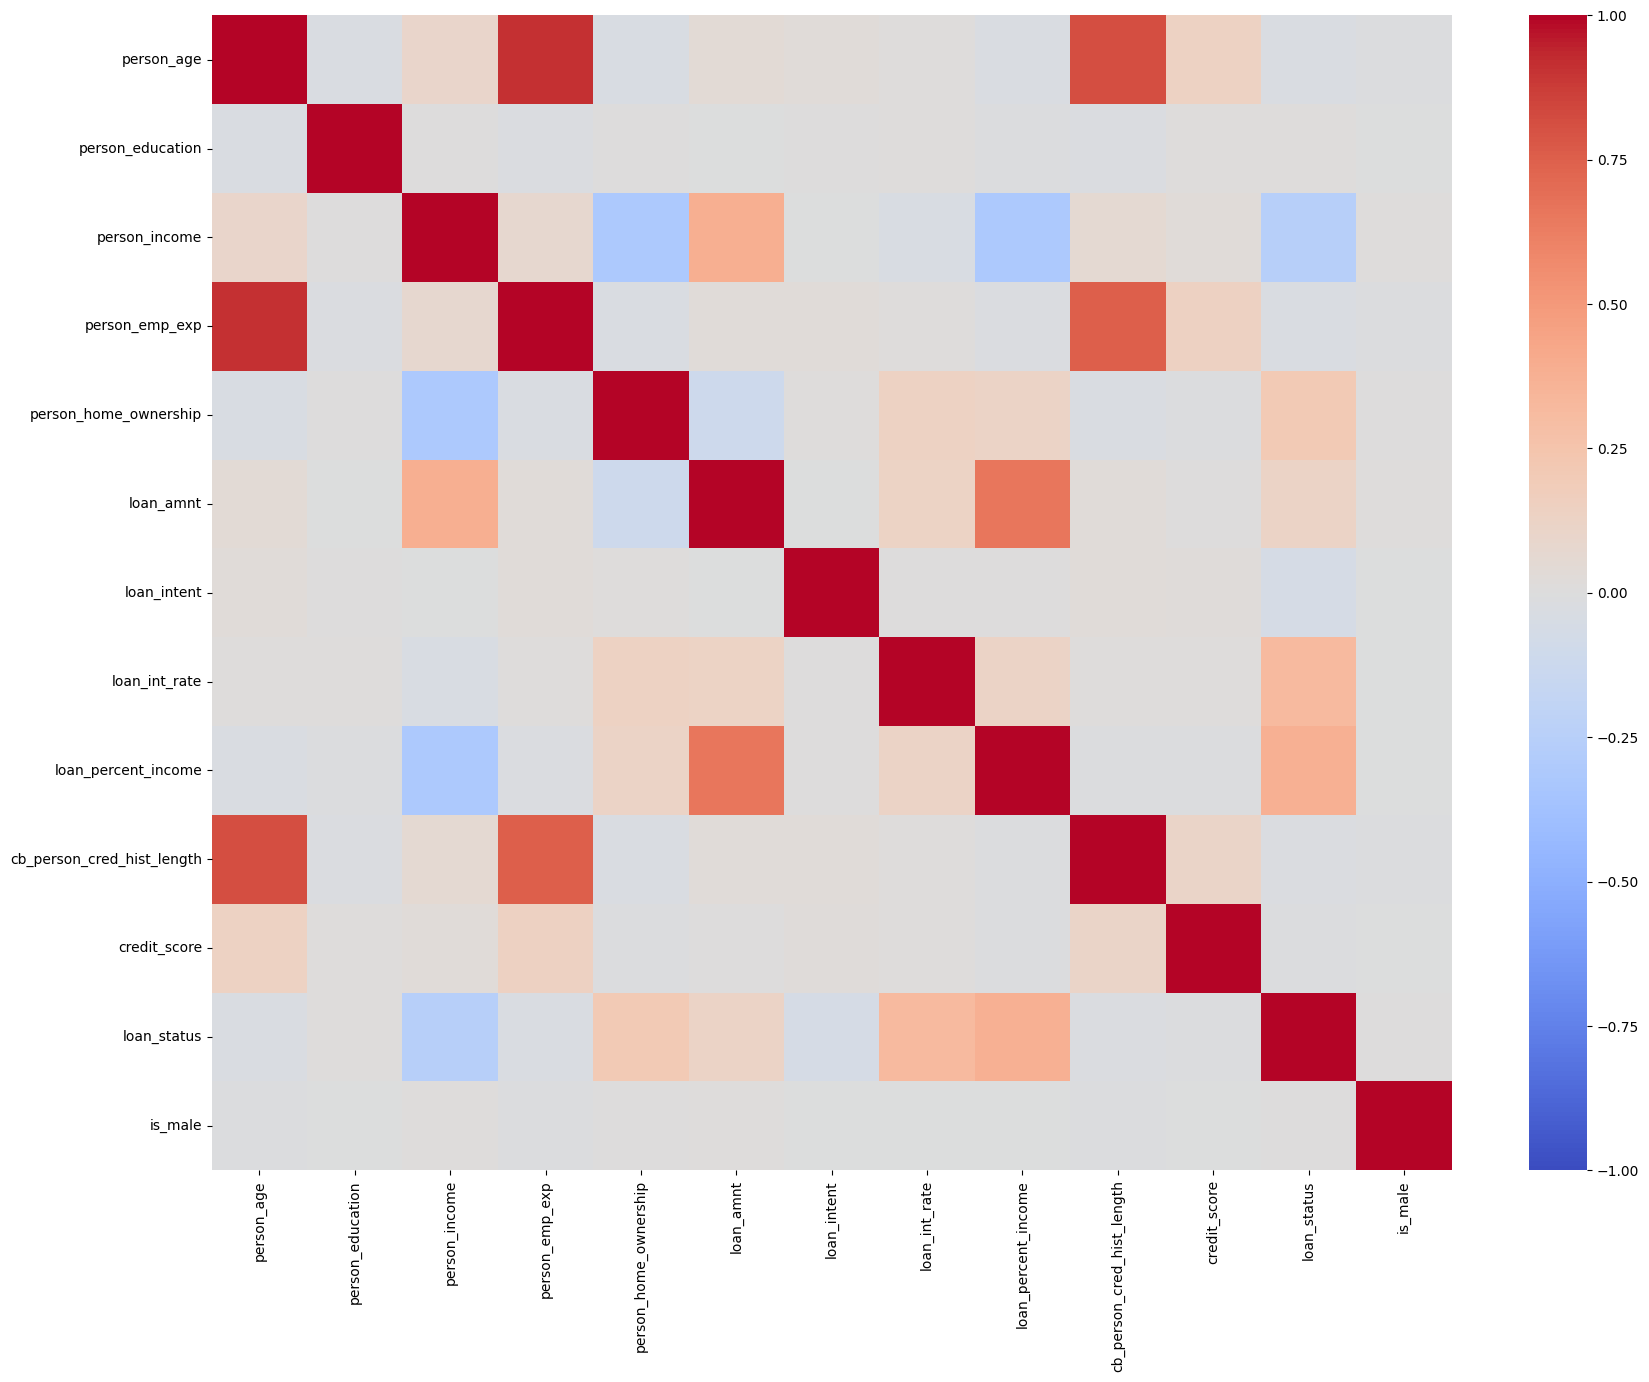

In [23]:
plt.figure(figsize=(20, 15))
sns.heatmap(correlation_matrix, annot=False, cmap='coolwarm', fmt=".2f", vmin=-1, vmax=1)

Easy to see that the one-hot represent better in correlation

## Split data

In [24]:
X_train = train_data_tr_encode.drop(columns=['loan_status'])
y_train = train_data_tr_encode['loan_status']

## Resampling

In [25]:
# Overall
print("The number of samples in the training set is: ", X_train.shape[0])
print("Class 0: ", y_train.value_counts()[0]*100/X_train.shape[0], "%")
print("Class 1: ", y_train.value_counts()[1]*100/X_train.shape[0], "%")

The number of samples in the training set is:  29435
Class 0:  77.81892305078988 %
Class 1:  22.181076949210123 %


In [26]:
# Over-sampling
smote = SMOTE(random_state=42)
X_train_res, y_train_res = smote.fit_resample(X_train, y_train)

print("The number of samples after SMOTE in the training set is: ", X_train_res.shape[0])
print("Class 0: ", y_train_res.value_counts()[0]*100/X_train_res.shape[0], "%")
print("Class 1: ", y_train_res.value_counts()[1]*100/X_train_res.shape[0], "%")

The number of samples after SMOTE in the training set is:  45812
Class 0:  50.0 %
Class 1:  50.0 %


In [27]:
# Cleaning Under-sampling
# Apply Tomek Links to clean the data
tomek = TomekLinks()
X_train_res, y_train_res = tomek.fit_resample(X_train_res, y_train_res)

print("The number of samples after applying Tomek Links is: ", X_train_res.shape[0])
print("Class 0: ", y_train_res.value_counts()[0]*100/X_train_res.shape[0], "%")
print("Class 1: ", y_train_res.value_counts()[1]*100/X_train_res.shape[0], "%")

The number of samples after applying Tomek Links is:  44117
Class 0:  51.921028175079904 %
Class 1:  48.078971824920096 %


## Scaling

In [29]:
scaler = StandardScaler()
X_train_res_scal = scaler.fit_transform(X_train_res)

## Feature Reduction

In [31]:
X_train_res_scal = pd.DataFrame(X_train_res_scal)
pca = PCA(n_components=len(X_train_res_scal.columns))
pca.fit(X_train_res_scal)
cumulative_variance = pca.explained_variance_ratio_.cumsum()

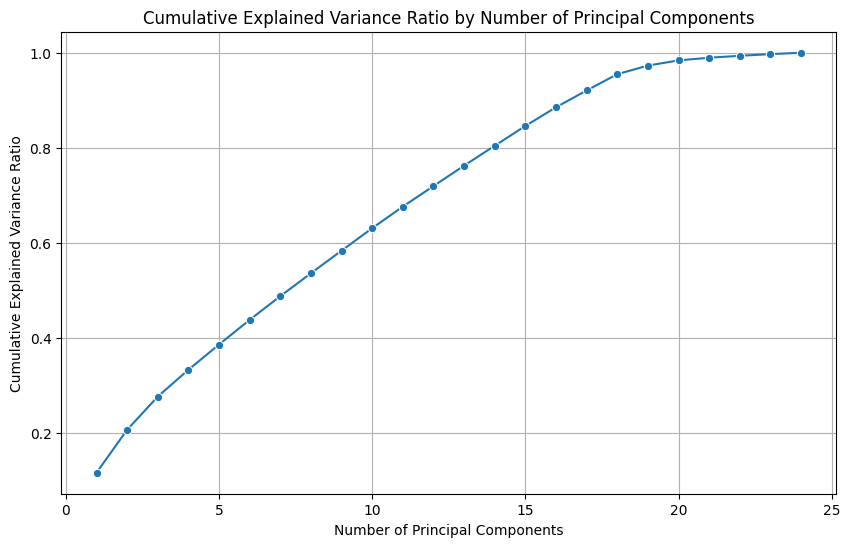

In [32]:
# Create a DataFrame for cumulative explained variance ratio
cvr = pd.DataFrame({
    'Number of Principal Components': range(1, len(cumulative_variance) + 1),
    'Cumulative Explained Variance Ratio': cumulative_variance
})

# Set up the figure
plt.figure(figsize=(10, 6))

# Create the line plot using Seaborn
sns.lineplot(data=cvr, 
             x='Number of Principal Components', 
             y='Cumulative Explained Variance Ratio', 
             marker='o')  # Adding markers for clarity

# Add title and labels
plt.title('Cumulative Explained Variance Ratio by Number of Principal Components')
plt.xlabel('Number of Principal Components')
plt.ylabel('Cumulative Explained Variance Ratio')

# Add grid lines for better readability
plt.grid(True)

# Show the figure
plt.show()

After scaling/resampling, take full features

In [ ]:
pca = PCA(n_components=len(X_train_res_scal.columns))
X_train_res_scal = pca.fit_transform(X_train_res_scal)

## Final Pipeline

In [33]:
# Define final pre-processing steps
def remove_outliners(df, features):
    temp_df = df.copy()
    for feature in features:
        Q1 = temp_df[feature].quantile(0.25)
        Q3 = temp_df[feature].quantile(0.75)
        IQR = Q3 - Q1
        temp_df = temp_df[(temp_df[feature] >= (Q1 - 1.5 * IQR)) & (temp_df[feature] <= (Q3 + 1.5 * IQR))]
    return temp_df

def dataset_encode(train_data):
    df = train_data.copy()
    # Gender: to true false one-hot
    df['is_male'] = df['person_gender'].map({'male': 1, 'female': 0})
    df.drop(columns=['person_gender'], inplace=True)

    # Previous loan: to true false one-hot
    df['previous_loan_defaults_on_file'] = df['previous_loan_defaults_on_file'].map({'Yes': 1, 'No': 0})
    df.drop(columns=['previous_loan_defaults_on_file'], inplace=True)

    # Since education is low, using one-hot encoding
    df = pd.get_dummies(df, columns=['person_education'], prefix='edu', dtype=int)

    # Home ownership also has few categories, so using one-hot encoding
    df = pd.get_dummies(df, columns=['person_home_ownership'], prefix='home', dtype=int)

    # Load intent also has few categories, so using one-hot encoding
    df = pd.get_dummies(df, columns=['loan_intent'], prefix='intent', dtype=int)
    
    return df

def dataset_split(train_data):
    X_train = train_data.drop(columns=['loan_status'])
    y_train = train_data['loan_status']
    return X_train, y_train

def dataset_resampling(X_train, y_train):
    X_train, y_train = SMOTE(random_state=42).fit_resample(X_train, y_train)
    X_train, y_train = TomekLinks().fit_resample(X_train, y_train)
    return X_train, y_train
    
def dataset_scaling_selecting(X_train, y_train):    
    scaler = StandardScaler()
    X_train = scaler.fit_transform(X_train)

    pca = PCA(n_components=len(X_train_res_scal.columns))
    X_train = pca.fit_transform(X_train)
    
    return X_train, y_train

In [91]:
train_data = pd.read_csv('data/train.csv')
train_data = remove_outliners(train_data, ['person_emp_exp', 'person_income', 'person_age'])
train_data = dataset_encode(train_data)

X_train, y_train = dataset_resampling(*dataset_split(train_data))

After checking, the scaling doesnt need and it may impact training process

# Load models

In [59]:
with open('rf_clf.pkl', 'rb') as file:
    rf_clf = pickle.load(file)
with open('xgb_clf.pkl', 'rb') as file:
    xg_clf = pickle.load(file)
with open('cb_clf.pkl', 'rb') as file:
    cat_clf = pickle.load(file)

# Modeling

## RandomForest

In [68]:
naive_rf = RandomForestClassifier(random_state=42)
naive_rf.fit(X_train, y_train)

RandomForestClassifier(random_state=42)

In [72]:
# Hyperparameter tuning for Random Forest

# Define the parameter search space
param_space = {
    'n_estimators': Integer(50, 500),
    'min_samples_split': Integer(2, 20),
    'min_samples_leaf': Integer(1, 20),
    'bootstrap': Categorical([True, False]),
    'max_features': Integer(10, 20),
    'class_weight': Categorical(['balanced', 'balanced_subsample', None])
}

# Create a StratifiedKFold object
cv = StratifiedKFold(n_splits=5)

# Configure the BayesSearchCV
rf_clf = BayesSearchCV(
    estimator=RandomForestClassifier(random_state=42, max_depth=None),
    search_spaces=param_space,
    scoring='roc_auc',
    n_iter=50,  # Number of parameter settings that are sampled
    cv=cv,  # Cross-validation splitting strategy
    n_jobs=-1,  # Use all available cores,
    optimizer_kwargs={'base_estimator': 'GP'},
    random_state=42
)

# Fit the grid search to the data
rf_clf.fit(X_train, y_train, callback=[DeltaYStopper(0.001), DeadlineStopper(60*45)])

# Get the best parameters
best_params = rf_clf.best_params_
print("Best parameters found: ", best_params)

c:\Users\Admin\miniconda3\envs\ml\Lib\site-packages\skopt\optimizer\optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "


Best parameters found:  OrderedDict({'bootstrap': False, 'class_weight': 'balanced', 'max_features': 10, 'min_samples_leaf': 9, 'min_samples_split': 2, 'n_estimators': 500})


## XGBoost

In [36]:
naive_xgb = XGBClassifier(random_state=42)
naive_xgb.fit(X_train, y_train)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=None, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=None, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=None, n_jobs=None,
              num_parallel_tree=None, random_state=42, ...)

In [197]:
# Hyperparameter tuning for XGBoost

# Define the parameter space
param_space = {
    'n_estimators': Integer(50, 500),
    'max_depth': Integer(5, 15),
    'learning_rate': Real(0.05, 0.2, prior='log-uniform'),
    'subsample': Real(0.4, 0.7),
    'colsample_bytree': Real(0.6, 1.0),
    'gamma': Real(0, 5),
    'reg_alpha': Real(0, 5),
    'reg_lambda': Real(3, 5),
    'scale_pos_weight': Real(1, 10)
}

# Create a StratifiedKFold object
cv = StratifiedKFold(n_splits=5)

# Create the BayesSearchCV object
xg_clf = BayesSearchCV(
    estimator=XGBClassifier(use_label_encoder=False, eval_metric='aucpr', random_state=42), 
    search_spaces=param_space, 
    n_iter=100, 
    cv=cv, 
    scoring='roc_auc', 
    n_jobs=-1,
    random_state=42,
    optimizer_kwargs={'base_estimator': 'GP'}
    )

# Fit the BayesSearchCV object to the data
xg_clf.fit(X_train, y_train, callback=[DeltaYStopper(0.001), DeadlineStopper(60*45)])

# Get the best parameters
best_params = xg_clf.best_params_
print("Best parameters found: ", best_params)

c:\Users\Admin\miniconda3\envs\ml\Lib\site-packages\xgboost\core.py:158: UserWarning: [18:03:08] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0c55ff5f71b100e98-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


Best parameters found:  OrderedDict({'colsample_bytree': 0.9724146901264212, 'gamma': 0.0, 'learning_rate': 0.2, 'max_depth': 11, 'n_estimators': 447, 'reg_alpha': 0.0, 'reg_lambda': 3.0, 'scale_pos_weight': 10.0, 'subsample': 0.7})


## Catboost

In [38]:
naive_cat = CatBoostClassifier(random_state=42, verbose=0, allow_writing_files=False)
naive_cat.fit(X_train, y_train)

In [37]:
# Hyperparameter tuning for CatBoost

# Define the parameter search space for CatBoost
param_space = {
    'iterations': Integer(50, 100),
    'depth': Integer(6, 15),
    'learning_rate': Real(0.01, 0.3, prior='log-uniform'),
    'l2_leaf_reg': Real(1, 10),
    'bagging_temperature': Real(0, 1),
    'border_count': Integer(32, 255),
    'scale_pos_weight': Real(1, 10)
}

# Create a StratifiedKFold object
cv = StratifiedKFold(n_splits=5)

# Configure the BayesSearchCV
cb_clf = BayesSearchCV(
    estimator=CatBoostClassifier(verbose=0, random_state=42, allow_writing_files=False),
    search_spaces=param_space,
    scoring='roc_auc',
    n_iter=50,  # Number of parameter settings that are sampled
    cv=cv,  # Cross-validation splitting strategy
    n_jobs=-1,  # Use all available cores
    optimizer_kwargs={'base_estimator': 'GP'},
    random_state=42
)

# Fit the BayesSearchCV to the data
cb_clf.fit(X_train, y_train, callback=[DeltaYStopper(0.001), DeadlineStopper(60*45)])

# Get the best parameters
best_params = cb_clf.best_params_
print("Best parameters found: ", best_params)

Best parameters found:  OrderedDict({'bagging_temperature': 0.18327927066752492, 'border_count': 254, 'depth': 6, 'iterations': 100, 'l2_leaf_reg': 3.2857457495313738, 'learning_rate': 0.29999999999999993, 'scale_pos_weight': 2.552866507744624})


## LightGBM

In [92]:
naive_lgbm = LGBMClassifier(random_state=42)
naive_lgbm.fit(X_train, y_train)

[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Number of positive: 21211, number of negative: 22906
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000283 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1807
[LightGBM] [Info] Number of data points in the train set: 44117, number of used features: 24
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.480790 -> initscore=-0.076879
[LightGBM] [Info] Start training from score -0.076879


LGBMClassifier(random_state=42)

## AdaBoost

In [102]:
naive_ada = AdaBoostClassifier(random_state=42)
naive_ada.fit(X_train, y_train)

c:\Users\Admin\miniconda3\envs\ml\Lib\site-packages\sklearn\ensemble\_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(


AdaBoostClassifier(random_state=42)

# Evaluation

In [103]:
model = naive_ada

In [104]:
y_train_pred = model.predict(X_train)

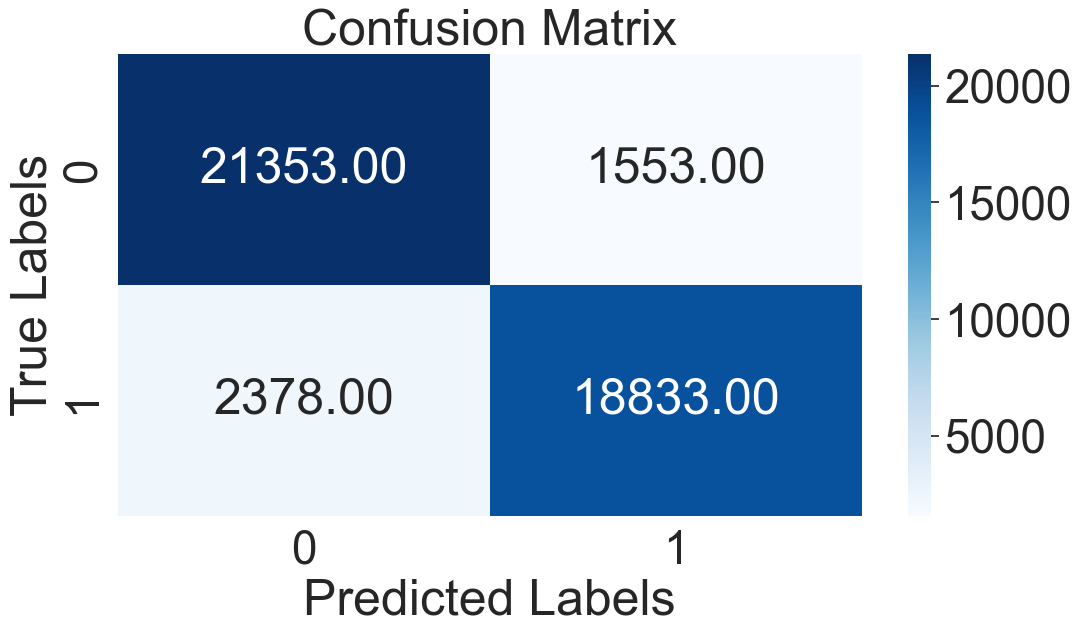

In [105]:
cm = confusion_matrix(y_train, y_train_pred)

# Create a heatmap using Seaborn

plt.figure(figsize=(12, 6))  # Set the figure size
sns.heatmap(cm, annot=True, fmt='0.2f', cmap='Blues', cbar=True)

# Add titles and labels

plt.title('Confusion Matrix')
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.show()

In [106]:
print(classification_report(y_train, y_train_pred))

              precision    recall  f1-score   support

           0       0.90      0.93      0.92     22906
           1       0.92      0.89      0.91     21211

    accuracy                           0.91     44117
   macro avg       0.91      0.91      0.91     44117
weighted avg       0.91      0.91      0.91     44117



# Real evaluation with y_test

In [88]:
# Select the model
model = naive_lgbm

In [107]:
# Read and process test data
test_data = pd.read_csv('data/test.csv')
test_data = dataset_encode(test_data)
X_test, y_test = dataset_split(test_data)
X_test, y_test = dataset_resampling(X_test, y_test)
# X_test, y_test = dataset_scaling_selecting(X_test, y_test)

In [108]:
# Make predictions
y_test_pred = model.predict(X_test)

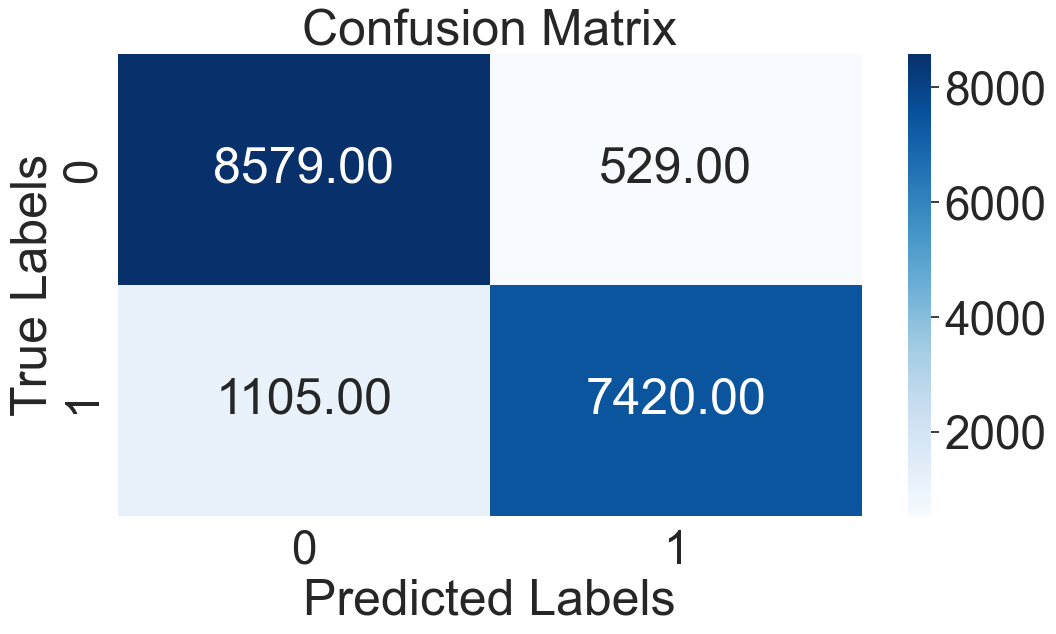

In [109]:
cm = confusion_matrix(y_test, y_test_pred)

# Create a heatmap using Seaborn

plt.figure(figsize=(12, 6))  # Set the figure size
sns.heatmap(cm, annot=True, fmt='0.2f', cmap='Blues', cbar=True)

# Add titles and labels

plt.title('Confusion Matrix')
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.show()

In [110]:
# Print classification report
print(classification_report(y_test, y_test_pred))
print(f'Train Accuracy: {accuracy_score(y_test, y_test_pred)}')
print(f'Test F1: {f1_score(y_test, y_test_pred)}')
print(f'Test Precision: {precision_score(y_test, y_test_pred)}')
print(f'Test Recall: {recall_score(y_test, y_test_pred)}')

              precision    recall  f1-score   support

           0       0.89      0.94      0.91      9108
           1       0.93      0.87      0.90      8525

    accuracy                           0.91     17633
   macro avg       0.91      0.91      0.91     17633
weighted avg       0.91      0.91      0.91     17633

Train Accuracy: 0.9073328418306584
Test F1: 0.9008134029379629
Test Precision: 0.9334507485218266
Test Recall: 0.8703812316715542


In [ ]:
y_scores = cross_val_score(model, X_train, y_train, cv=5,
                             scoring='roc_auc', n_jobs=-1)

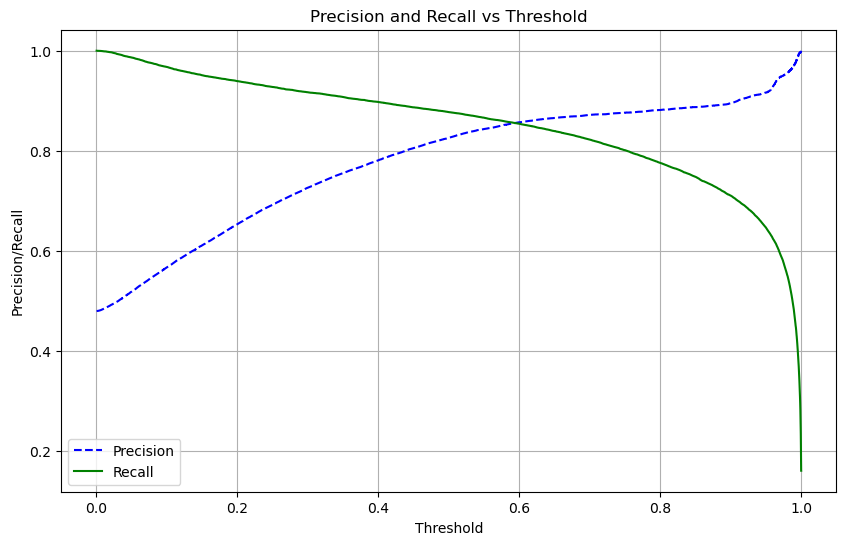

In [45]:
precisions, recalls, thresholds = precision_recall_curve(y_train, y_scores[:, -1])
plt.figure(figsize=(10, 6))
plt.plot(thresholds, precisions[:-1], 'b--', label='Precision')
plt.plot(thresholds, recalls[:-1], 'g-', label='Recall')
plt.xlabel('Threshold')
plt.ylabel('Precision/Recall')
plt.title('Precision and Recall vs Threshold')
plt.legend(loc='best')
plt.grid(True)
plt.show()

ROC AUC Score: 0.9115501391810178


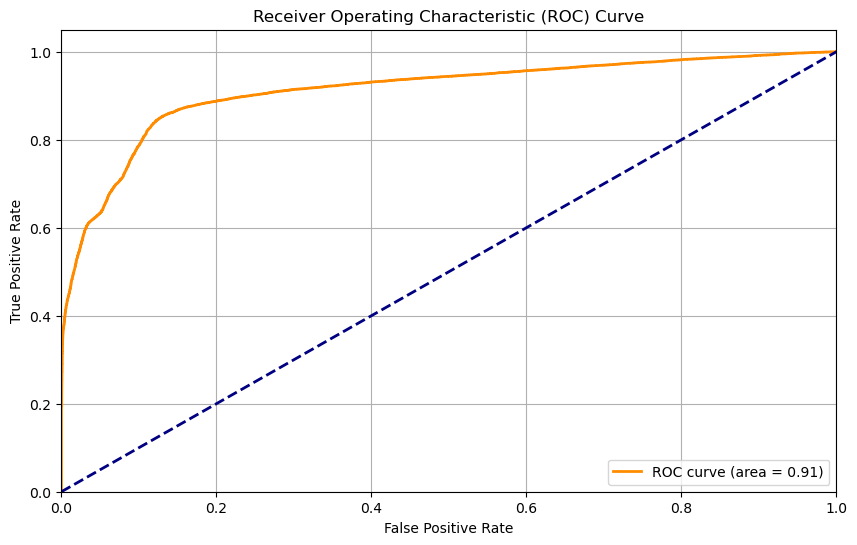

In [56]:
# Compute ROC curve and ROC area
fpr, tpr, thresholds = roc_curve(y_train, y_scores[:, -1])
roc_auc = roc_auc_score(y_train, y_scores[:, -1])

print(f"ROC AUC Score: {roc_auc}")

# Plot ROC curve
plt.figure(figsize=(10, 6))
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (area = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc='lower right')
plt.grid(True)
plt.show()

In [97]:
# Define a low FPR threshold and a minimum TPR threshold
low_fpr_threshold = 0.1  # Example: FPR should be less than 0.1
min_tpr_threshold = 0.7  # Example: TPR should be at least 0.7

# Find the index of the threshold that meets the criteria
indices = np.where((fpr <= low_fpr_threshold) & (tpr >= min_tpr_threshold))[0]
if len(indices) > 0:
    optimal_idx = indices[0]
    optimal_threshold = thresholds[optimal_idx]
    print(f"Optimal Threshold: {optimal_threshold}")
else:
    print("No threshold meets the criteria.")
    optimal_threshold = None

Optimal Threshold: 0.9106378199317564


In [110]:
# Predict probabilities on the test set
y_test_proba = rf_clf.predict_proba(X_test)[:, 1]

# Apply the optimal threshold to make final predictions
y_test_pred = (y_test_proba >= optimal_threshold).astype(int)

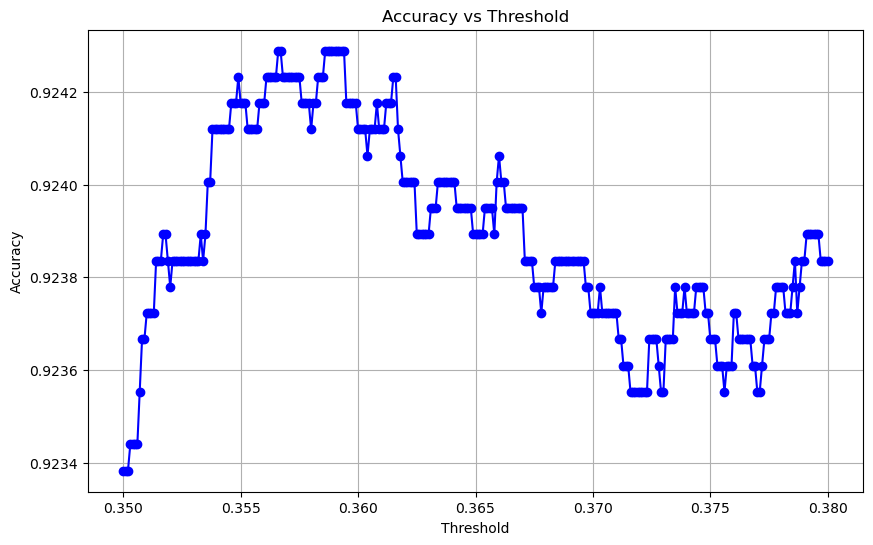

In [ ]:
from sklearn.metrics import accuracy_score
import matplotlib.pyplot as plt
import numpy as np

# Predict probabilities on the test set
y_test_proba = rf_clf.predict_proba(X_test)[:, 1]

# Define the range of thresholds
thresholds = np.arange(0.35, 0.38, 0.0001)

# Calculate accuracy for each threshold
accuracies = []
max = 0
for threshold in thresholds:
    y_test_pred = (y_test_proba >= threshold).astype(int)
    accuracy = accuracy_score(y_test, y_test_pred)
    accuracies.append(accuracy)
    if accuracy > max:
        max = accuracy
        optimal_threshold = threshold

# Plot the accuracy against the thresholds
plt.figure(figsize=(10, 6))
plt.plot(thresholds, accuracies, marker='o', linestyle='-', color='b')
plt.xlabel('Threshold')
plt.ylabel('Accuracy')
plt.title('Accuracy vs Threshold')
plt.grid(True)
plt.show()

# Save Models

In [270]:
# Save the model
with open('rf_clf.pkl', 'wb') as model_file:
    pickle.dump(rf_clf, model_file)
with open('xg_clf.pkl', 'wb') as model_file:
    pickle.dump(xg_clf, model_file)
with open('cb_clf.pkl', 'wb') as model_file:
    pickle.dump(cb_clf, model_file)
with open('vc_clf.pkl', 'wb') as model_file:
    pickle.dump(vc_clf, model_file)

In [272]:
# Extract best parameters
rf_best_params = rf_clf.best_params_
xg_best_params = xg_clf.best_params_
cb_best_params = cb_clf.best_params_

# Save the best parameters to a file
with open('best_params.pkl', 'wb') as file:
    pickle.dump({'rf_best_params': rf_best_params, 'xg_best_params': xg_best_params, 'cb_best_params': cb_best_params}, file)

# Read the best parameters from the file
with open('best_params.pkl', 'rb') as file:
    best_params = pickle.load(file)

print(best_params)

{'rf_best_params': OrderedDict({'bootstrap': False, 'class_weight': 'balanced', 'max_features': 10, 'min_samples_leaf': 9, 'min_samples_split': 2, 'n_estimators': 500}), 'xg_best_params': OrderedDict({'colsample_bytree': 0.9724146901264212, 'gamma': 0.0, 'learning_rate': 0.2, 'max_depth': 11, 'n_estimators': 447, 'reg_alpha': 0.0, 'reg_lambda': 3.0, 'scale_pos_weight': 10.0, 'subsample': 0.7}), 'cb_best_params': OrderedDict({'bagging_temperature': 0.18327927066752492, 'border_count': 254, 'depth': 6, 'iterations': 100, 'l2_leaf_reg': 3.2857457495313738, 'learning_rate': 0.29999999999999993, 'scale_pos_weight': 2.552866507744624})}


# Stacking Ensemble

In [145]:
X_test_real, X_test_valid, y_test_real, y_test_valid = train_test_split(X_test, y_test, test_size=0.2, random_state=42)
X_test_real, y_test_real = dataset_train_resampling(X_test_real, y_test_real)
X_test_valid, y_test_valid = dataset_train_resampling(X_test_valid, y_test_valid)

train_stack = np.column_stack((rf_clf.predict(X_test_valid), xg_clf.predict(X_test_valid), cb_clf.predict(X_test_valid)))

In [146]:
final_model = ExtraTreesClassifier(random_state=42, n_estimators=10, max_depth=10, min_samples_leaf=1000)
final_model.fit(train_stack, y_test_valid)

ExtraTreesClassifier(max_depth=10, min_samples_leaf=1000, n_estimators=10,
                     random_state=42)

In [149]:
y_test_real_pred = final_model.predict(np.column_stack((rf_clf.predict(X_test_real), xg_clf.predict(X_test_real), cb_clf.predict(X_test_real))))

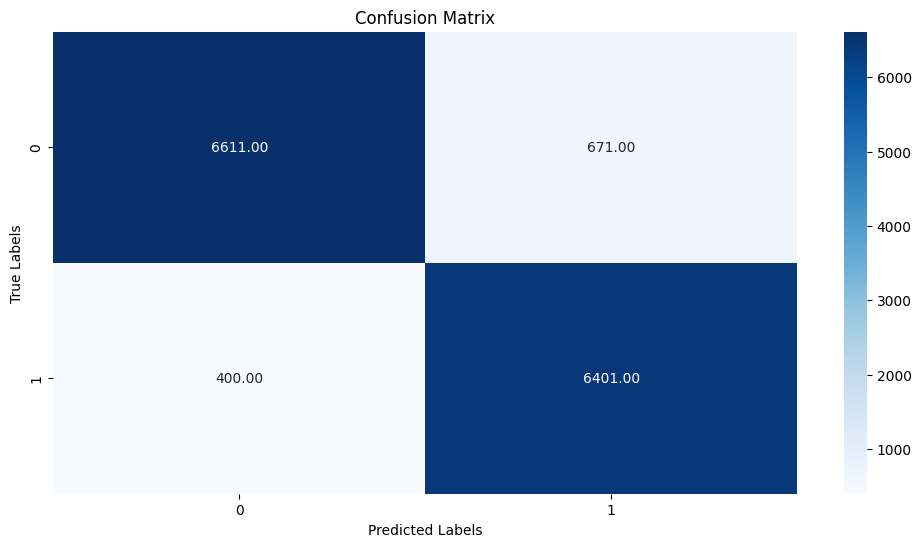

In [150]:
cm = confusion_matrix(y_test_real, y_test_real_pred)

# Create a heatmap using Seaborn

plt.figure(figsize=(12, 6))  # Set the figure size
sns.heatmap(cm, annot=True, fmt='0.2f', cmap='Blues', cbar=True)

# Add titles and labels

plt.title('Confusion Matrix')
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.show()

In [151]:
# Print classification report
print(classification_report(y_test_real, y_test_real_pred))

              precision    recall  f1-score   support

           0       0.94      0.91      0.93      7282
           1       0.91      0.94      0.92      6801

    accuracy                           0.92     14083
   macro avg       0.92      0.92      0.92     14083
weighted avg       0.92      0.92      0.92     14083



# Voting

In [49]:
xg = naive_xgb
rf = naive_rf
cb = naive_cat

In [257]:
xg = XGBClassifier(**xg_clf.best_params_,use_label_encoder=False, eval_metric='aucpr', random_state=42)
rf = RandomForestClassifier(**rf_clf.best_params_, random_state=42, max_depth=None)
cb = CatBoostClassifier(**cb_clf.best_params_,verbose=0, random_state=42, allow_writing_files=False)


In [50]:
vc_clf = VotingClassifier(estimators=[('rf', rf), ('xg', xg), ('cb', cb)], voting='soft')

In [51]:
vc_clf.fit(X_train, y_train)

VotingClassifier(estimators=[('rf', RandomForestClassifier(random_state=42)),
                             ('xg',
                              XGBClassifier(base_score=None, booster=None,
                                            callbacks=None,
                                            colsample_bylevel=None,
                                            colsample_bynode=None,
                                            colsample_bytree=None, device=None,
                                            early_stopping_rounds=None,
                                            enable_categorical=False,
                                            eval_metric=None,
                                            feature_types=None, gamma=None,
                                            grow_policy=None,
                                            importance_type...
                                            learning_rate=None, max_bin=None,
                                            max_cat_threshold=None,
                                            max_cat_to_onehot=None,
                                            max_delta_step=None, max_depth=None,
                                            max_leaves=None,
                                            min_child_weight=None, missing=nan,
                                            monotone_constraints=None,
                                            multi_strategy=None,
                                            n_estimators=None, n_jobs=None,
                                            num_parallel_tree=None,
                                            random_state=42, ...)),
                             ('cb',
                              <catboost.core.CatBoostClassifier object at 0x0000023862227FE0>)],
                 voting='soft')